In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
dataset_path = "../../dataset/RML25_COMBINED.hdf5"

In [3]:
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
import matplotlib.patches as patches
from itertools import cycle
from scipy import special


In [4]:
with h5py.File(dataset_path, 'r') as f:
    X = f['X'][::2048]  
    Y = f['Y'][::2048]
    Z = f['Z'][::2048]

In [5]:

epsilon = 1e-8  # A small value to avoid division by zero
X_min = np.min(X, axis=1, keepdims=True)
X_max = np.max(X, axis=1, keepdims=True)

# Compute range
X_range = X_max - X_min

# Create a mask where range is 0
mask = X_range == 0

# Normalize to [-1, 1] (Avoid division by zero by adding epsilon)
X = np.where(mask, 0, 2 * (X - X_min) / (X_range + epsilon) - 1)


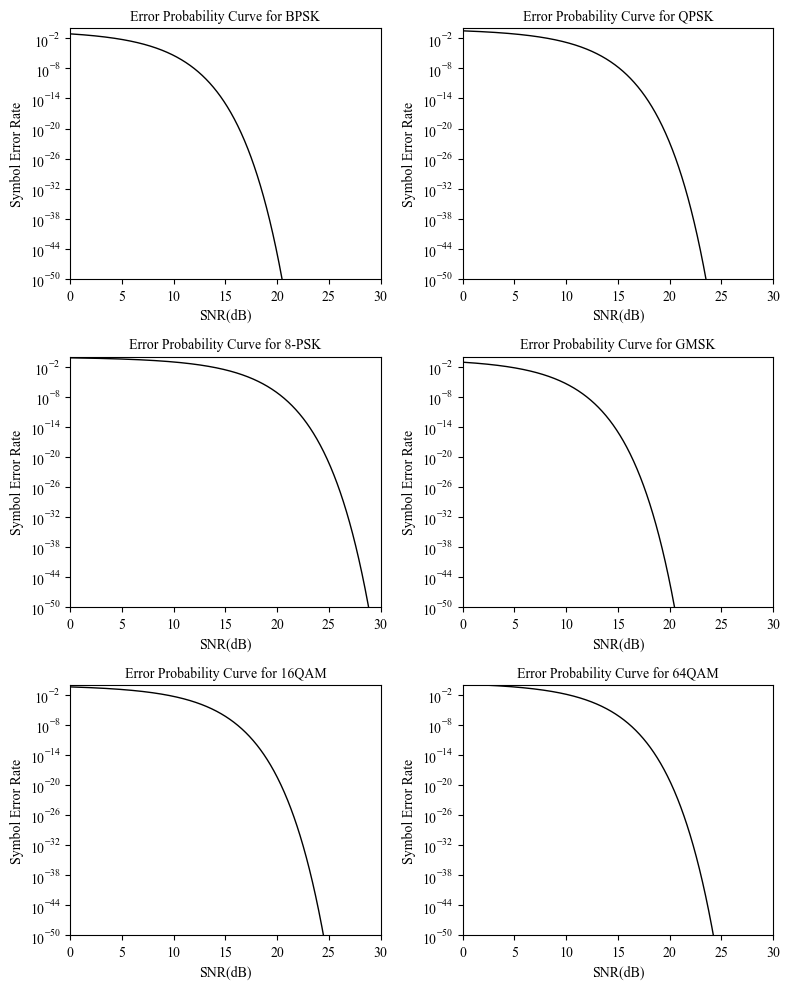

In [4]:


def db_to_linear(snr_db):
    return 10 ** (snr_db / 10)

def Q_func(x):
    return (special.erfc(x / np.sqrt(2)) * 0.5)

def probability_error_bpsk(snr_db):
    snr_linear = db_to_linear(snr_db)
    pe_bpsk = Q_func(np.sqrt(2 *  snr_linear))
    return pe_bpsk

# Probability of error for MPSK (for M > 2)
def probability_error_mpsk(snr_db, m):
    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Calculate the probability of error for MPSK
    sin_term = np.sin(np.pi / m) ** 2
    pe_mpsk = special.erfc(np.sqrt(snr_linear * sin_term))

    return pe_mpsk

def probability_error_qpsk(snr_db):
    snr_linear = db_to_linear(snr_db)
    pe_qpsk = 2*Q_func(np.sqrt(snr_linear))
    return pe_qpsk

def probability_error_gmsk(snr_db):
    snr_linear = db_to_linear(snr_db)
    pe_gmsk = Q_func(np.sqrt(2 * snr_linear))
    return pe_gmsk

def probability_error_16qam(snr_db):
    snr_linear = db_to_linear(snr_db)
    pe_16qam = 3*Q_func(np.sqrt(snr_linear * 4/5)) * 3 / 4
    return pe_16qam

def probability_error_64qam(snr_db):
    snr_linear = db_to_linear(snr_db)
    pe_16qam = 7*Q_func(np.sqrt(snr_linear * 6/7)) * 7 / 6
    return pe_16qam

SNR_VALUES = np.linspace(0, 30, 1000)


plt.figure(figsize=(8, 10))
# Plotting the result
# plt.figure()
# plt.semilogy(SNR_VALUES, probability_error_bpsk(SNR_VALUES), 'bs-', label='Theory', linewidth=2)
# # plt.axis([0, 30, 10**-50, 1])
# plt.grid(True)
# plt.legend()
# plt.xlabel('Es/No, dB')
# plt.ylabel('Symbol Error Rate')
# plt.title('Symbol Error Probability for BPSK')
# plt.show()

selected_classes = ["BPSK", "QPSK", "8-PSK", "GMSK", "16QAM", "64QAM"]
for i, selected_class in enumerate(selected_classes):
    plt.subplot(3, 2, i + 1)
    if selected_class == "BPSK":
        plt.semilogy(SNR_VALUES, probability_error_bpsk(SNR_VALUES), '' , linewidth=1, color="black")
    elif selected_class == "QPSK":
        plt.semilogy(SNR_VALUES, probability_error_qpsk(SNR_VALUES), '', linewidth=1, color="black")
    elif selected_class == "8-PSK":
        plt.semilogy(SNR_VALUES, probability_error_mpsk(SNR_VALUES, 8), '', linewidth=1, color="black")
    elif selected_class == "GMSK":
        plt.semilogy(SNR_VALUES, probability_error_gmsk(SNR_VALUES), '', linewidth=1, color="black")
    elif selected_class == "16QAM":
        plt.semilogy(SNR_VALUES, probability_error_16qam(SNR_VALUES), '', linewidth=1, color="black")
    elif selected_class == "64QAM":
        plt.semilogy(SNR_VALUES, probability_error_64qam(SNR_VALUES), '', linewidth=1, color="black")

    plt.axis([0, 30, 10**-50, 1])
    # plt.grid(True, linestyle='dotted', linewidth=1)
    # plt.legend()
    plt.xlabel('SNR(dB)')
    plt.ylabel('Symbol Error Rate')
    plt.title(f'Error Probability Curve for {selected_class}', fontsize=10)


plt.tight_layout()
plt.savefig("./visualization/probability_error.pdf", format="pdf")
plt.show()

In [6]:
all_classes = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM',
    '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC',
    'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK'
]

# Plot constellation diagrams for the extracted dataset
def plot_constellation_snr_levels(modulation_class_index, extracted_classes, X, Y, Z):
        # Get modulation class name from extracted_classes
        class_name = extracted_classes[modulation_class_index]

        # Find indices of the target modulation class
        selected_class_indices = np.where(Y == modulation_class_index)[0]

        # Get unique SNR levels
        snr_values = np.unique(Z)

        # Plot constellation diagrams for all SNR levels
        plt.figure(figsize=(16, 20))
        for i, snr in enumerate(snr_values):
            # Find indices corresponding to the current SNR level
            snr_indices = selected_class_indices[np.where(Z[selected_class_indices] == snr)[0]]

            if len(snr_indices) == 0:
                continue

            # Extract the first sample for the current SNR level
            iq_samples = X[snr_indices[0]]
            # print(iq_samples.shape)
            # break
            # Separate into in-phase (I) and quadrature (Q) components
            I = iq_samples[:, 0].flatten()
            Q = iq_samples[:, 1].flatten()

            # Plot the scatter plot
            ax = plt.subplot(5, 4, i + 1)
            ax.scatter(I, Q, s=5, alpha=0.8, color='black')
            # ax.set_title(f"SNR: {snr}dB", fontsize=10, fontweight='bold')
            plt.text(0.5, -0.1, f"SNR: {snr}dB", fontsize=20, fontweight='bold', transform=ax.transAxes, ha='center', va='center')
            ax.axis('off')


        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.savefig(f"./visualization/constellation{classes[modulation_class_index]}.pdf", format="pdf")
        plt.show()


# Paths to extracted dataset and relevant parameters
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK', 'GFSK'
]

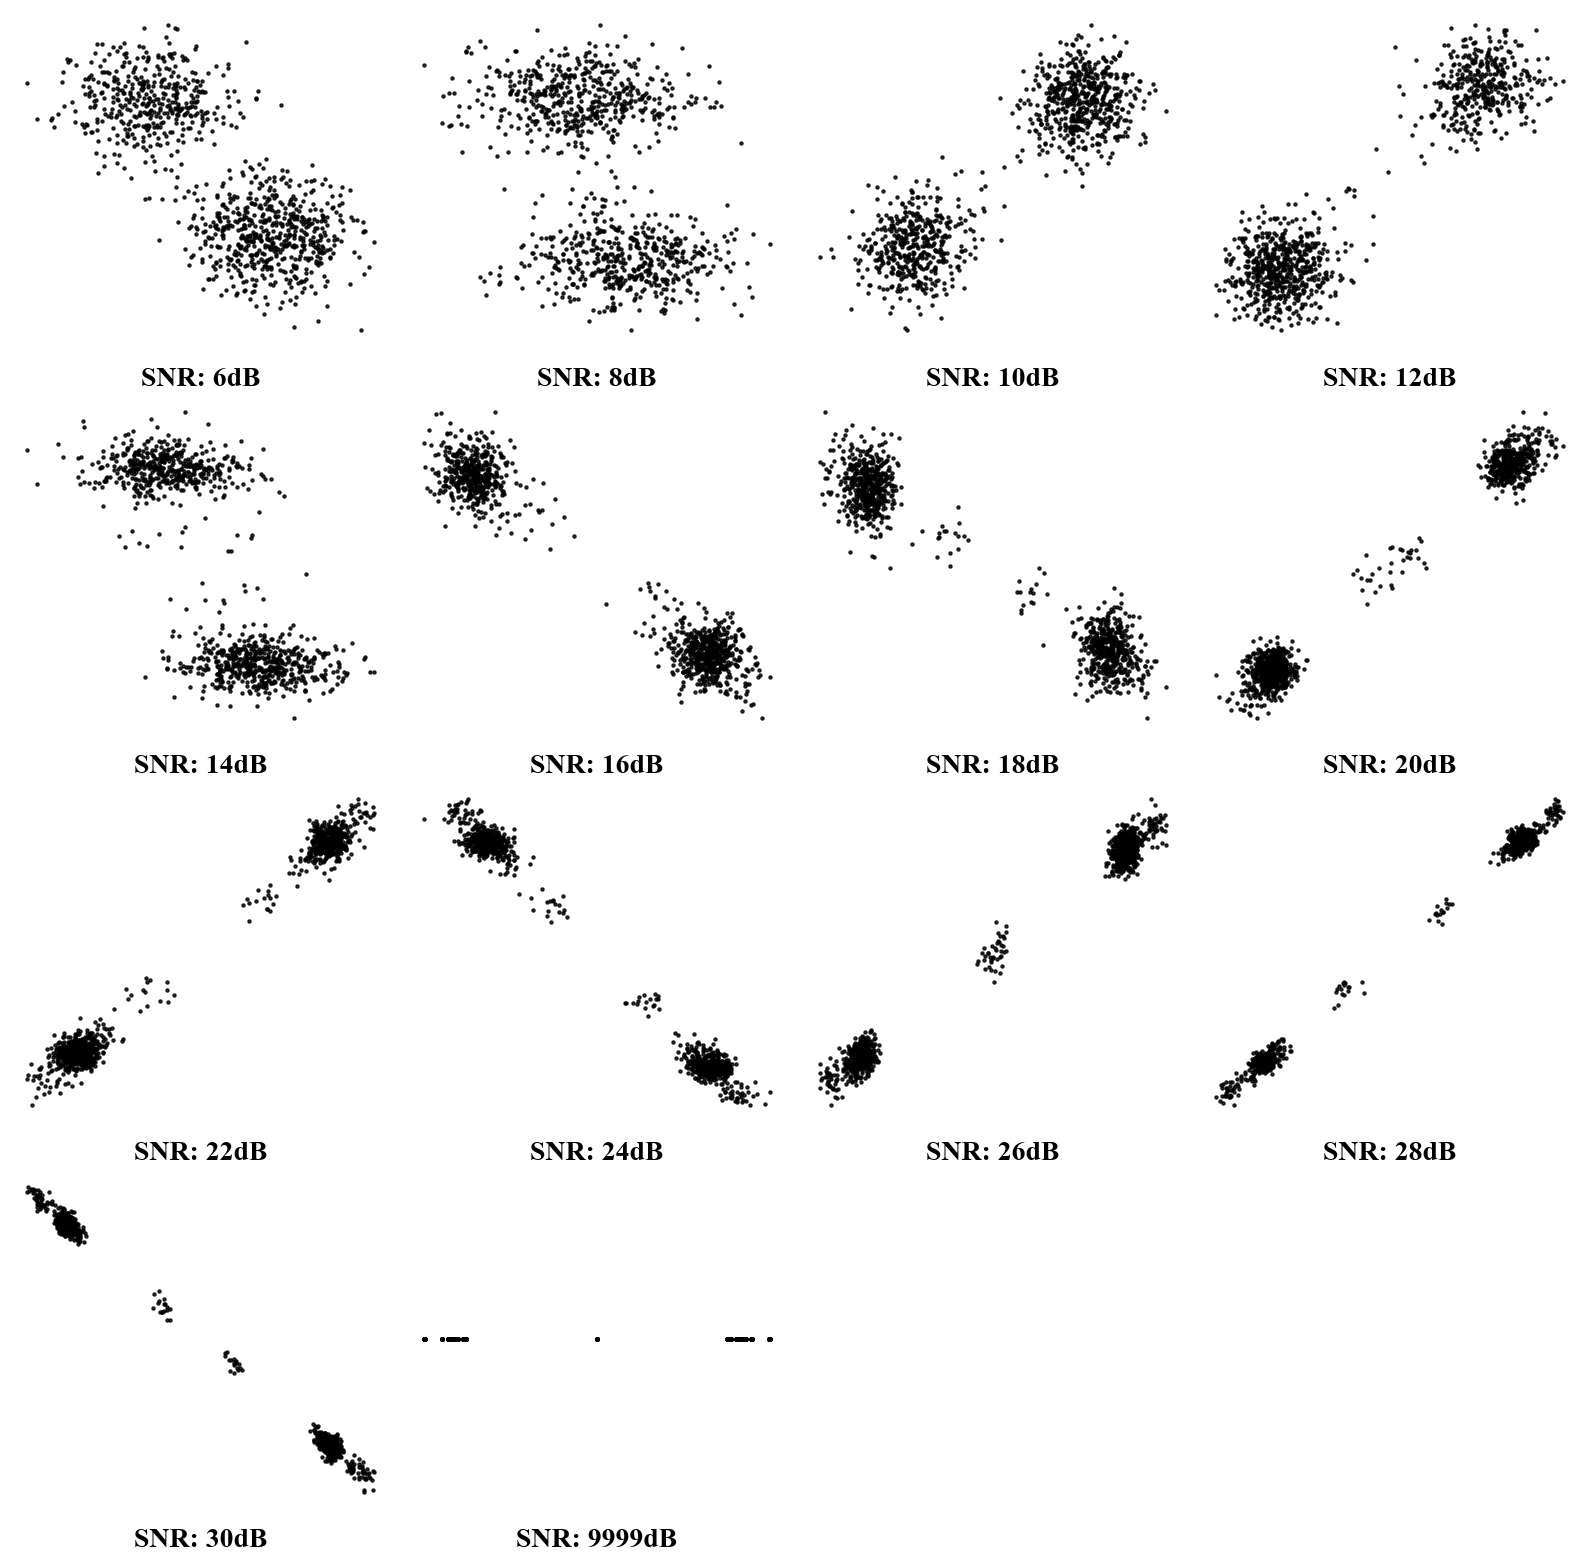

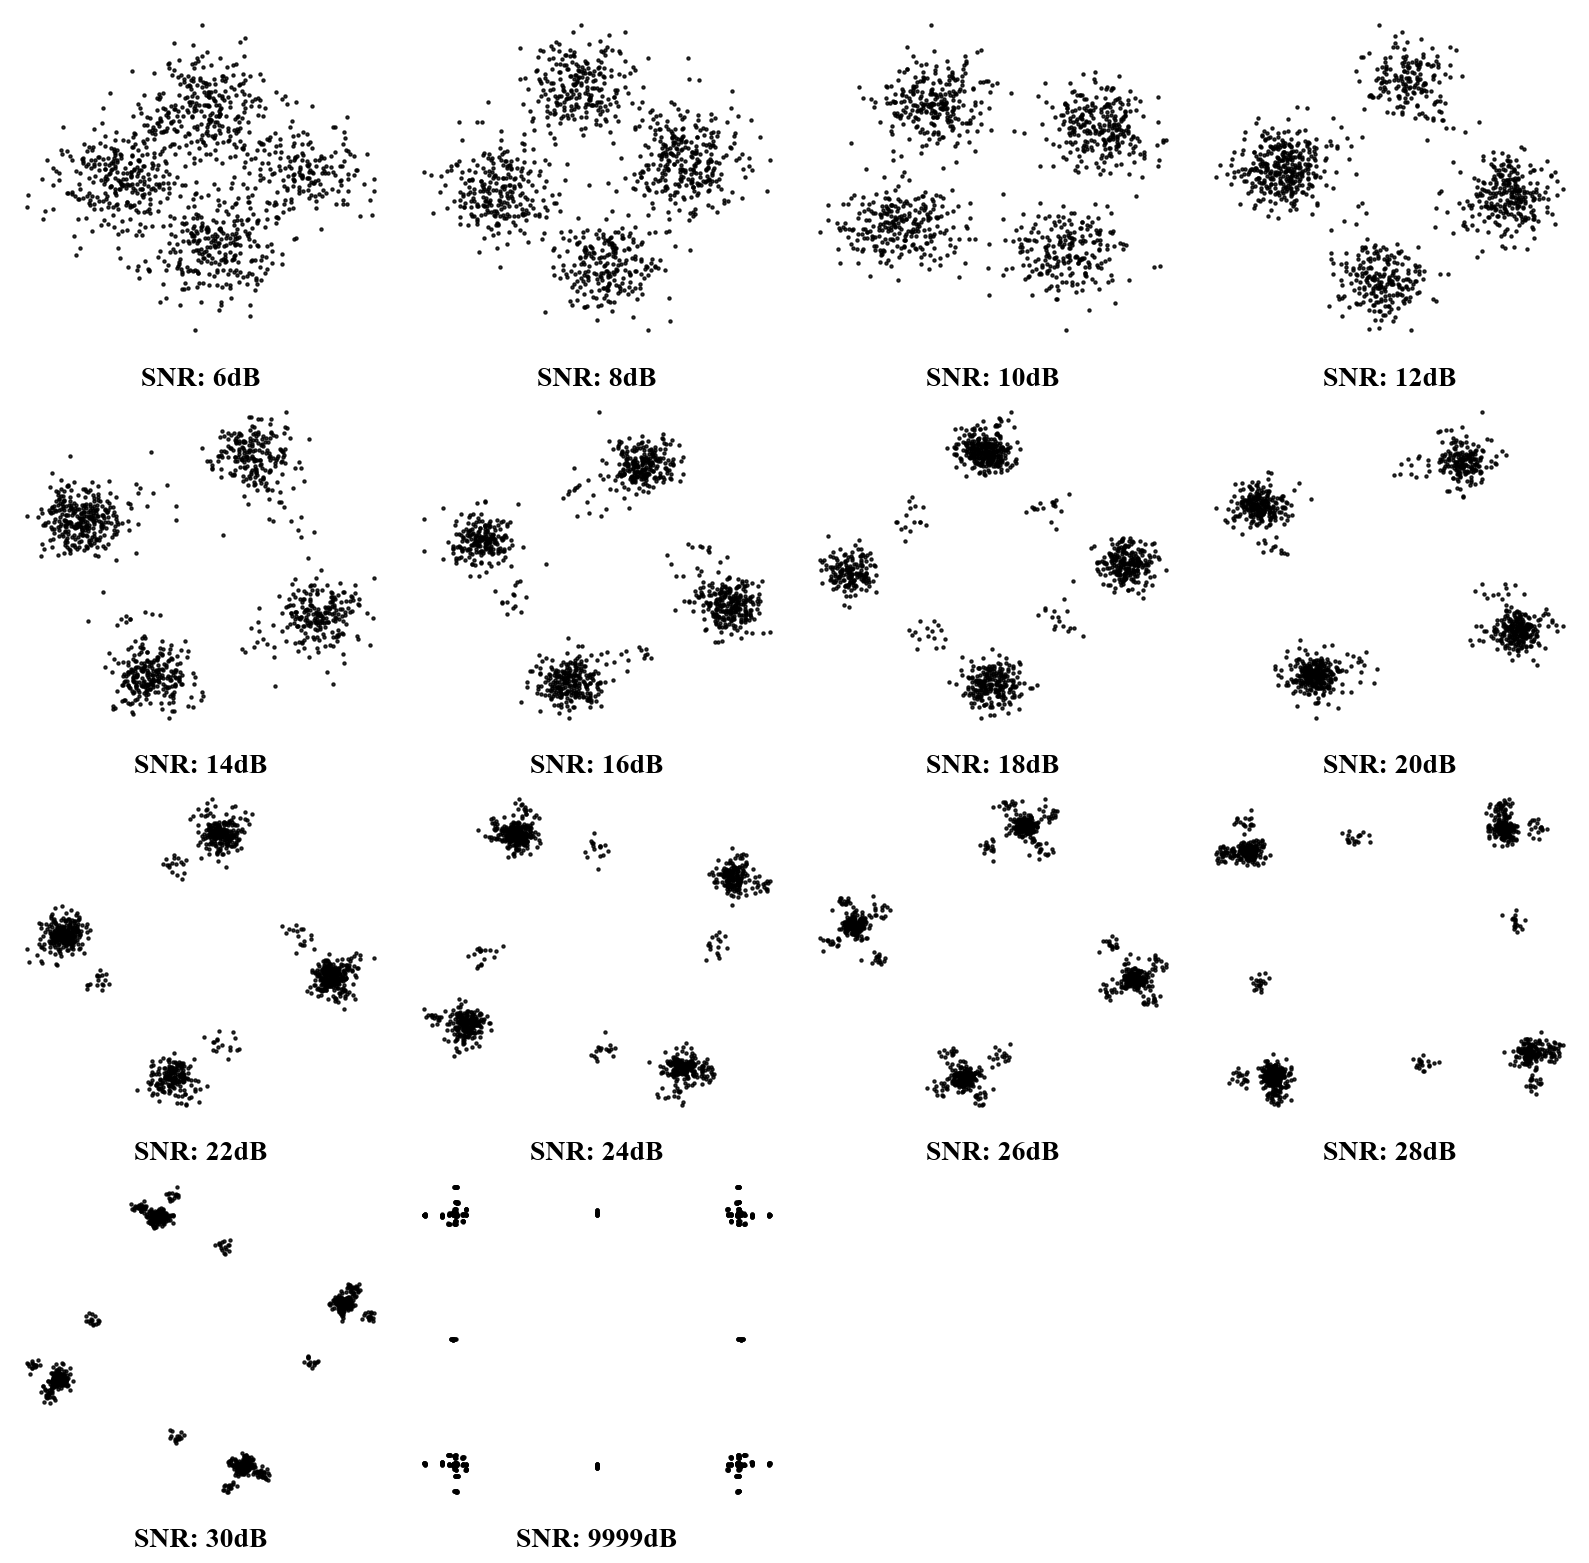

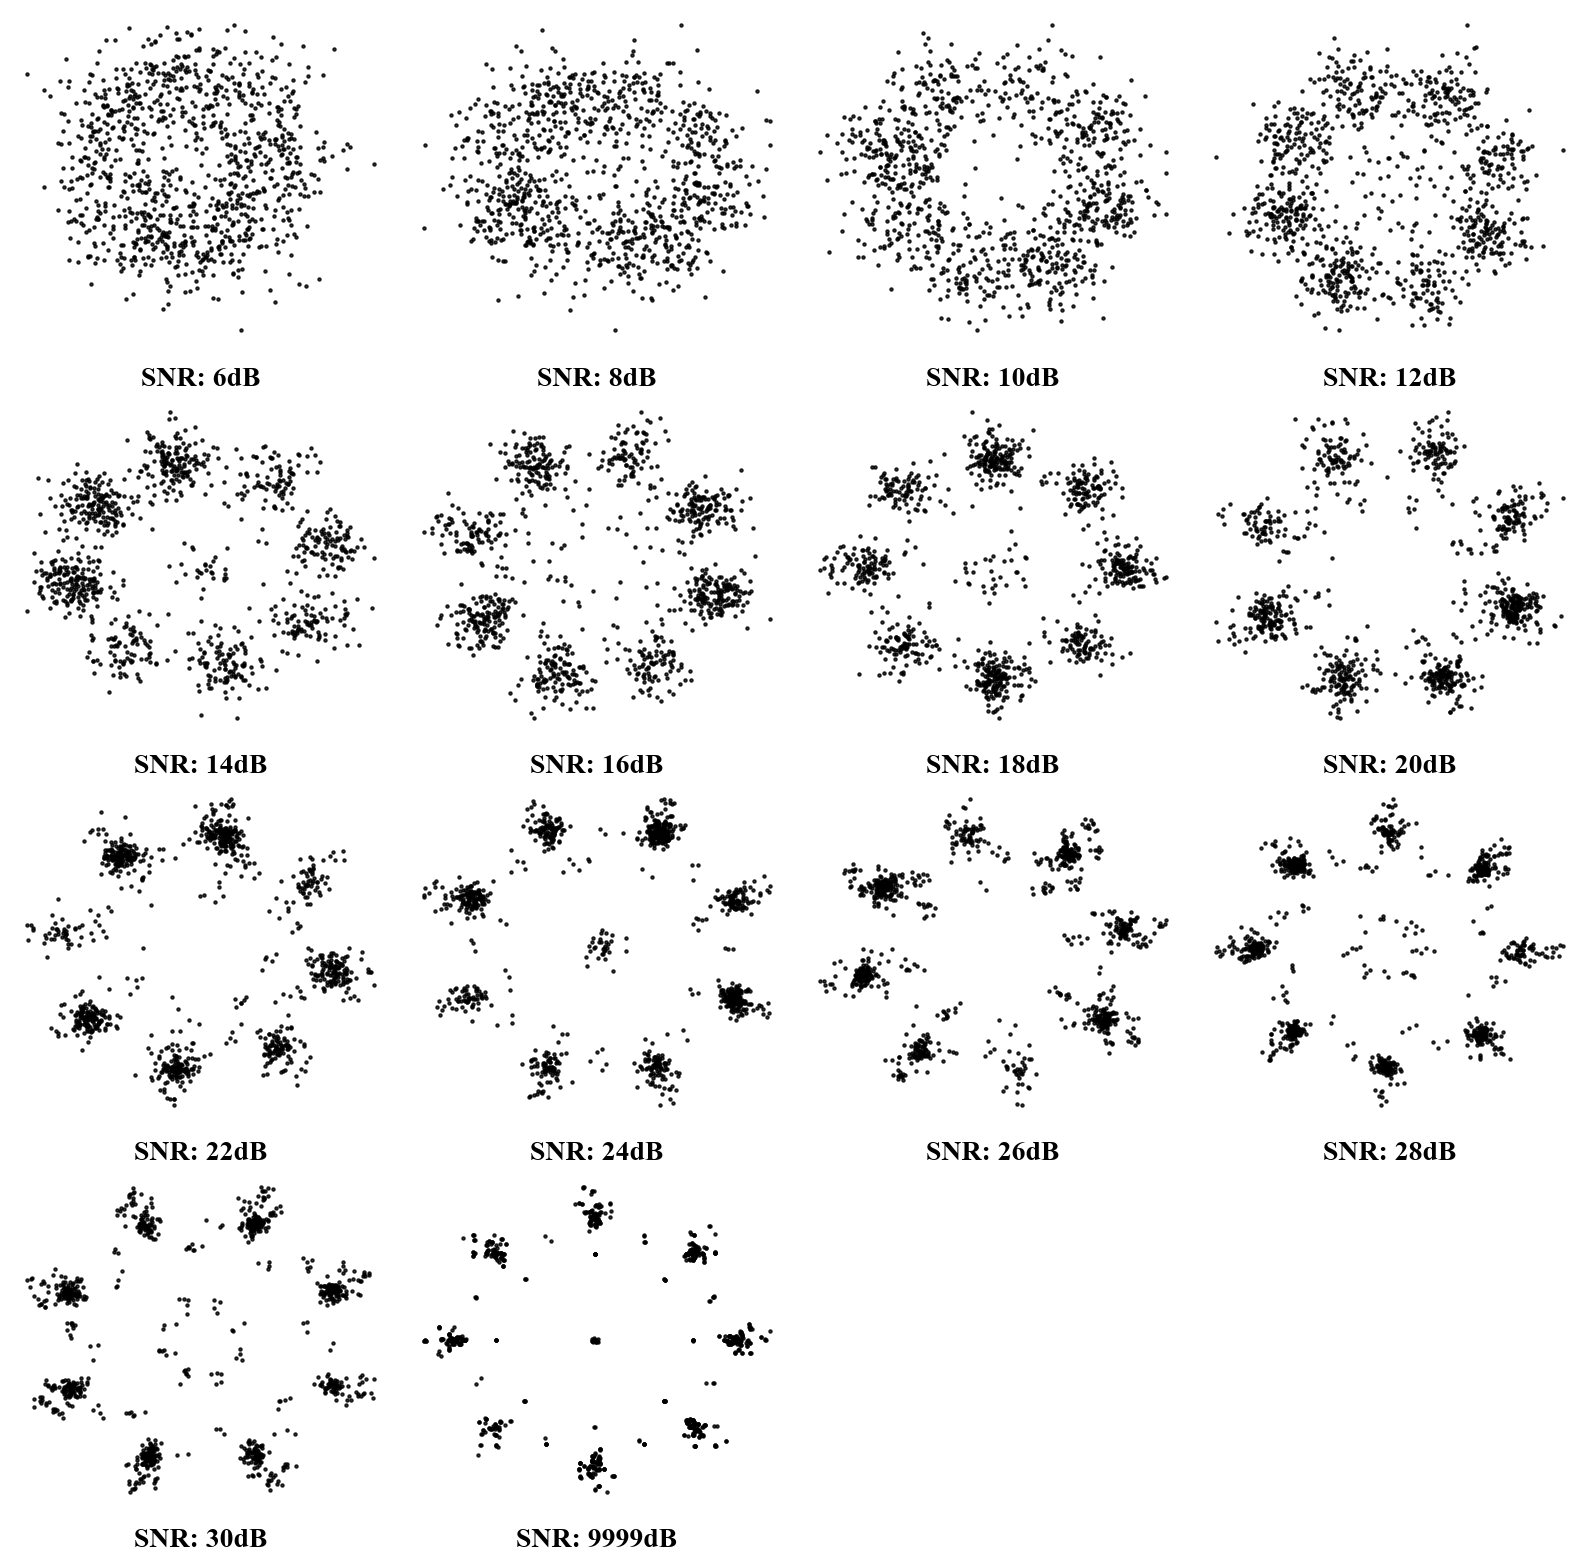

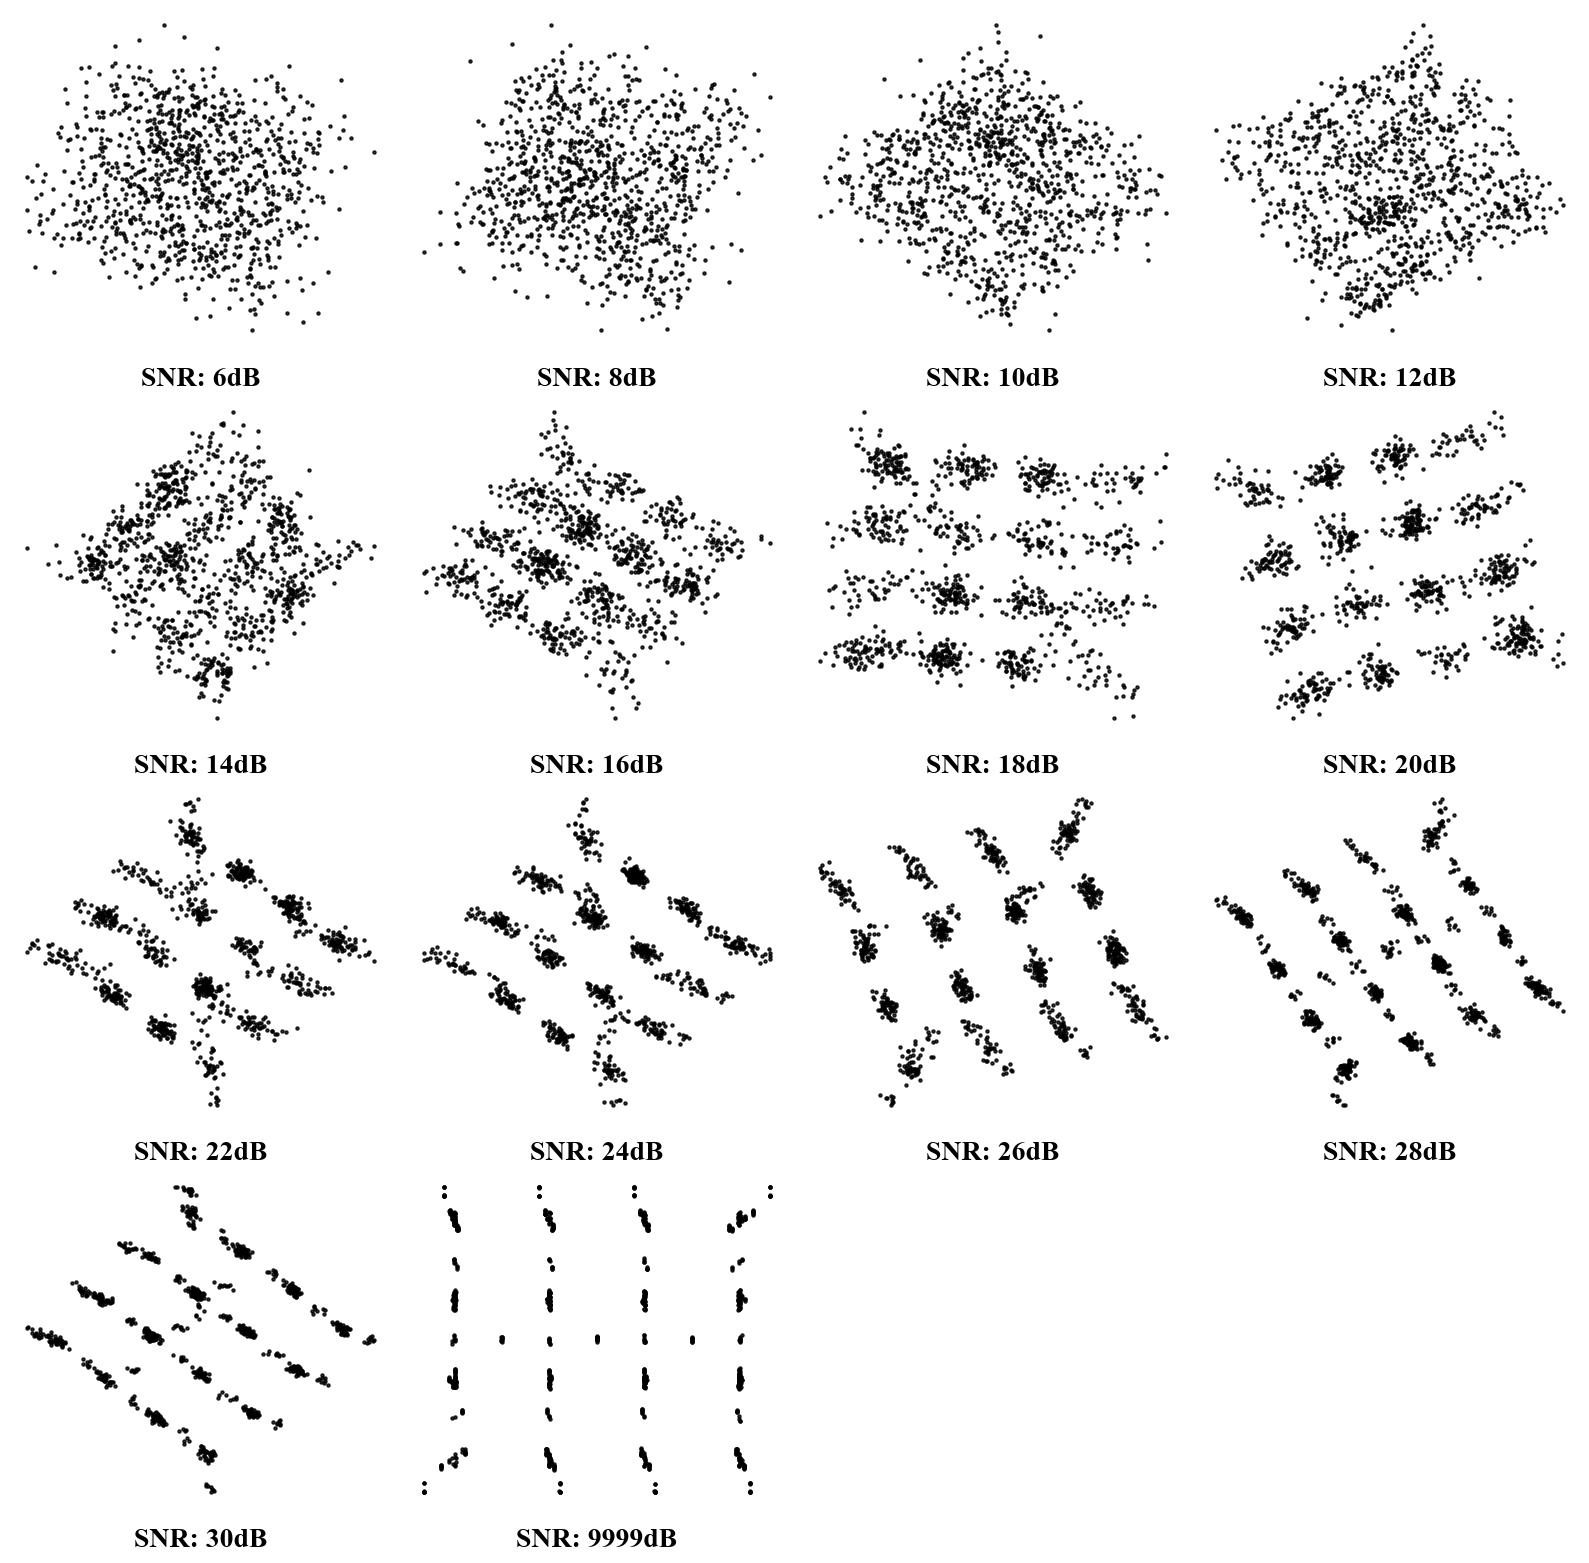

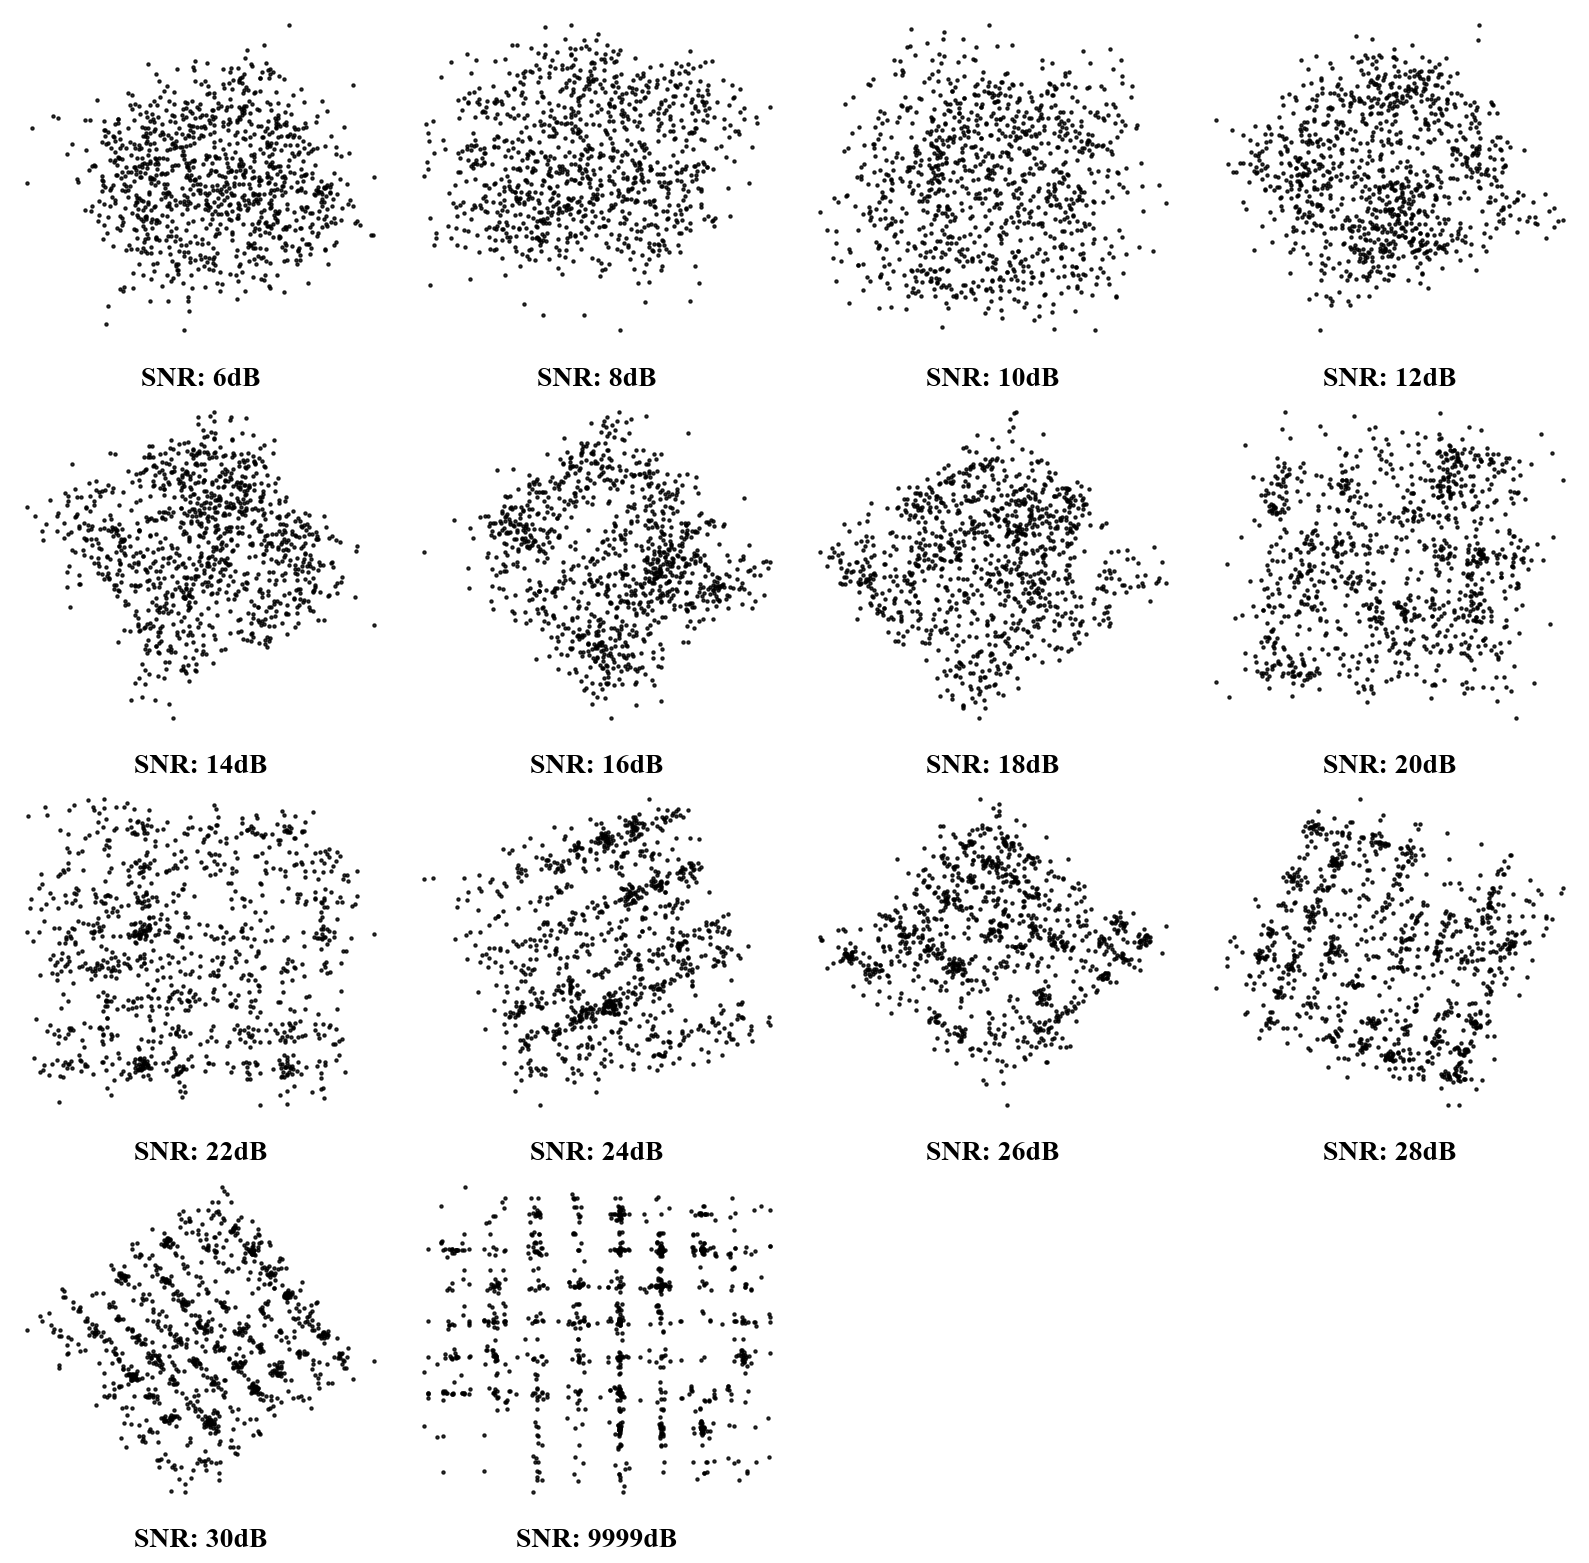

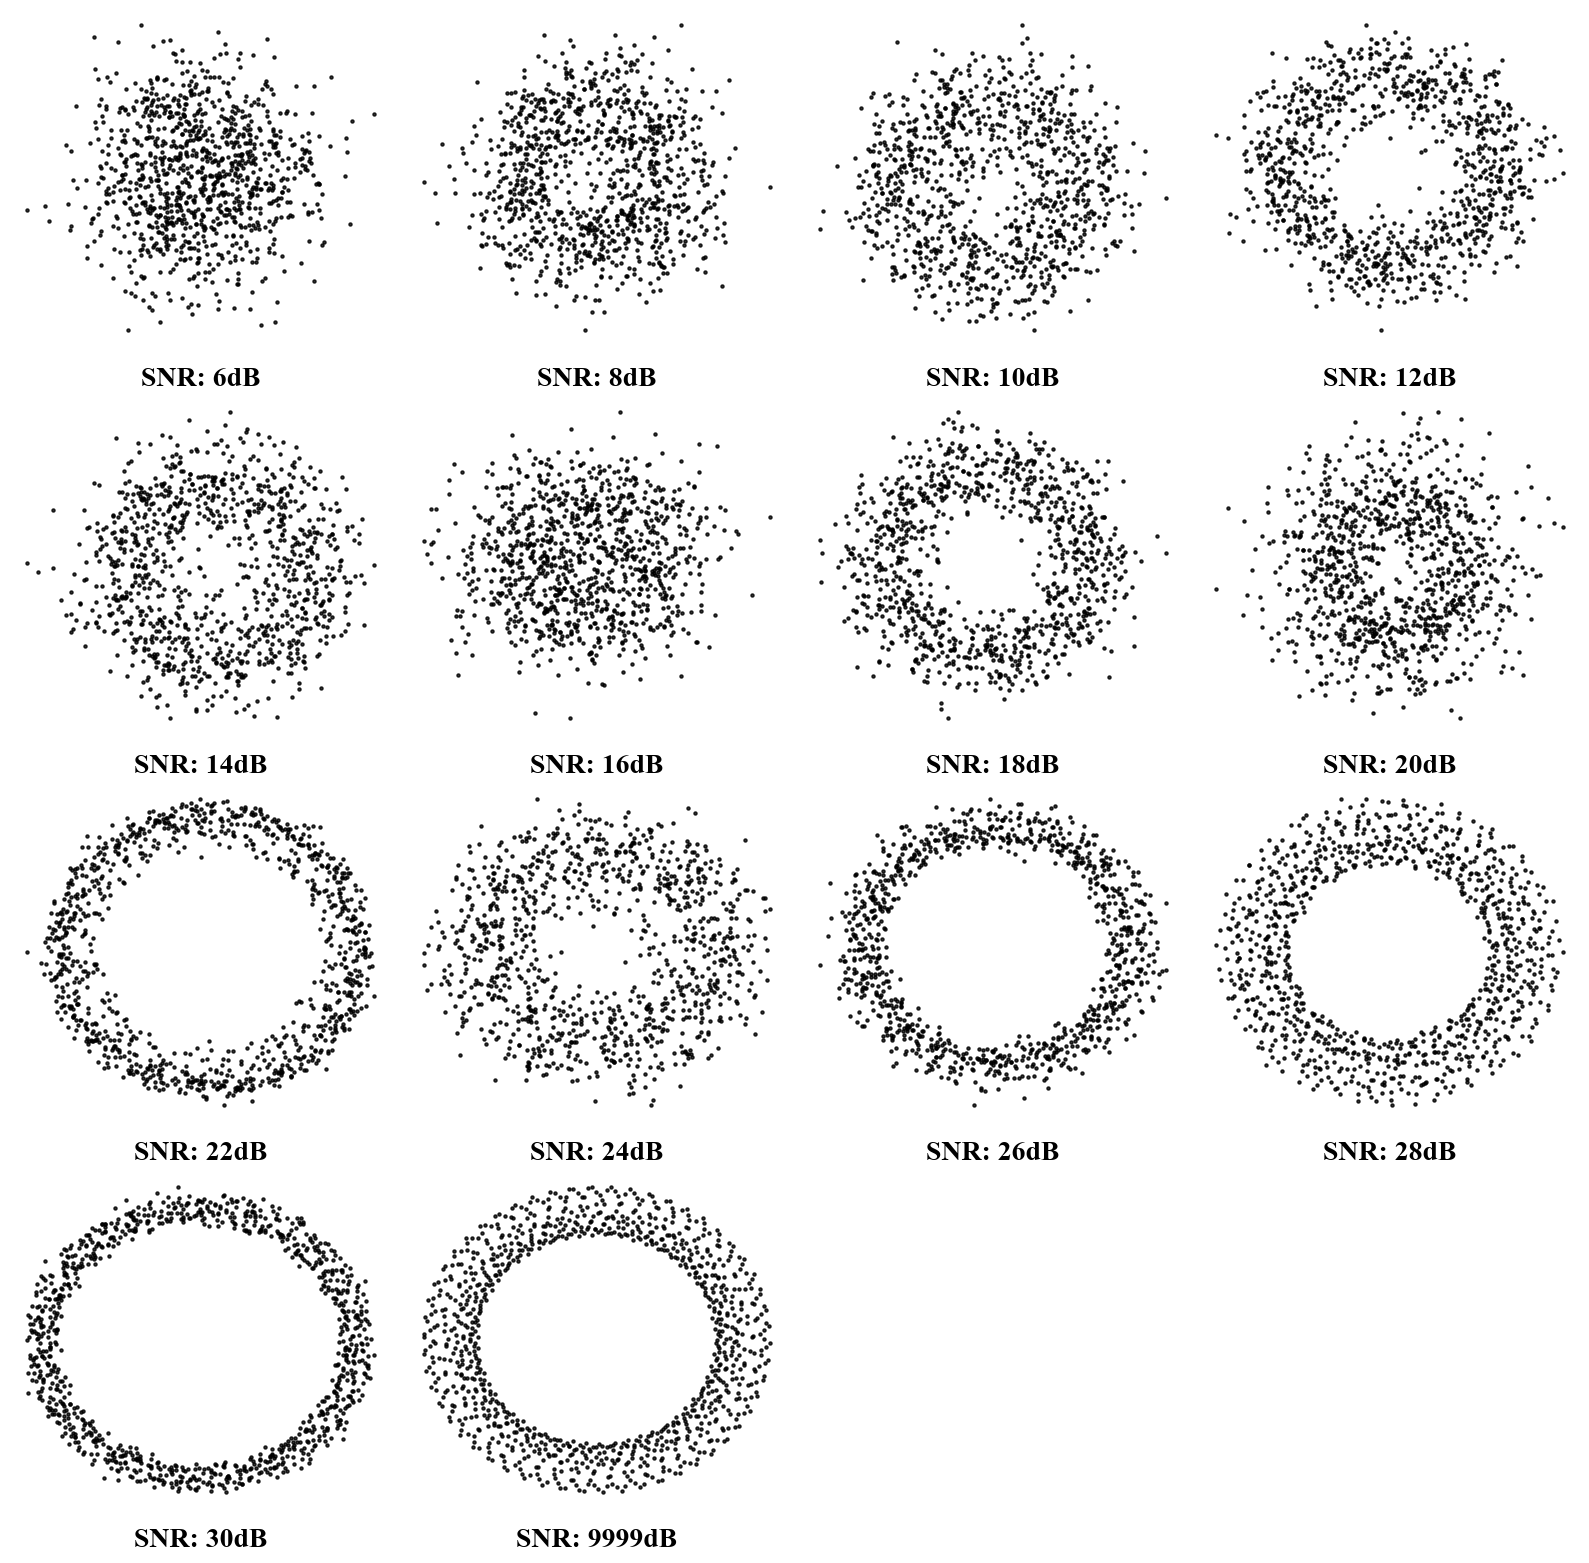

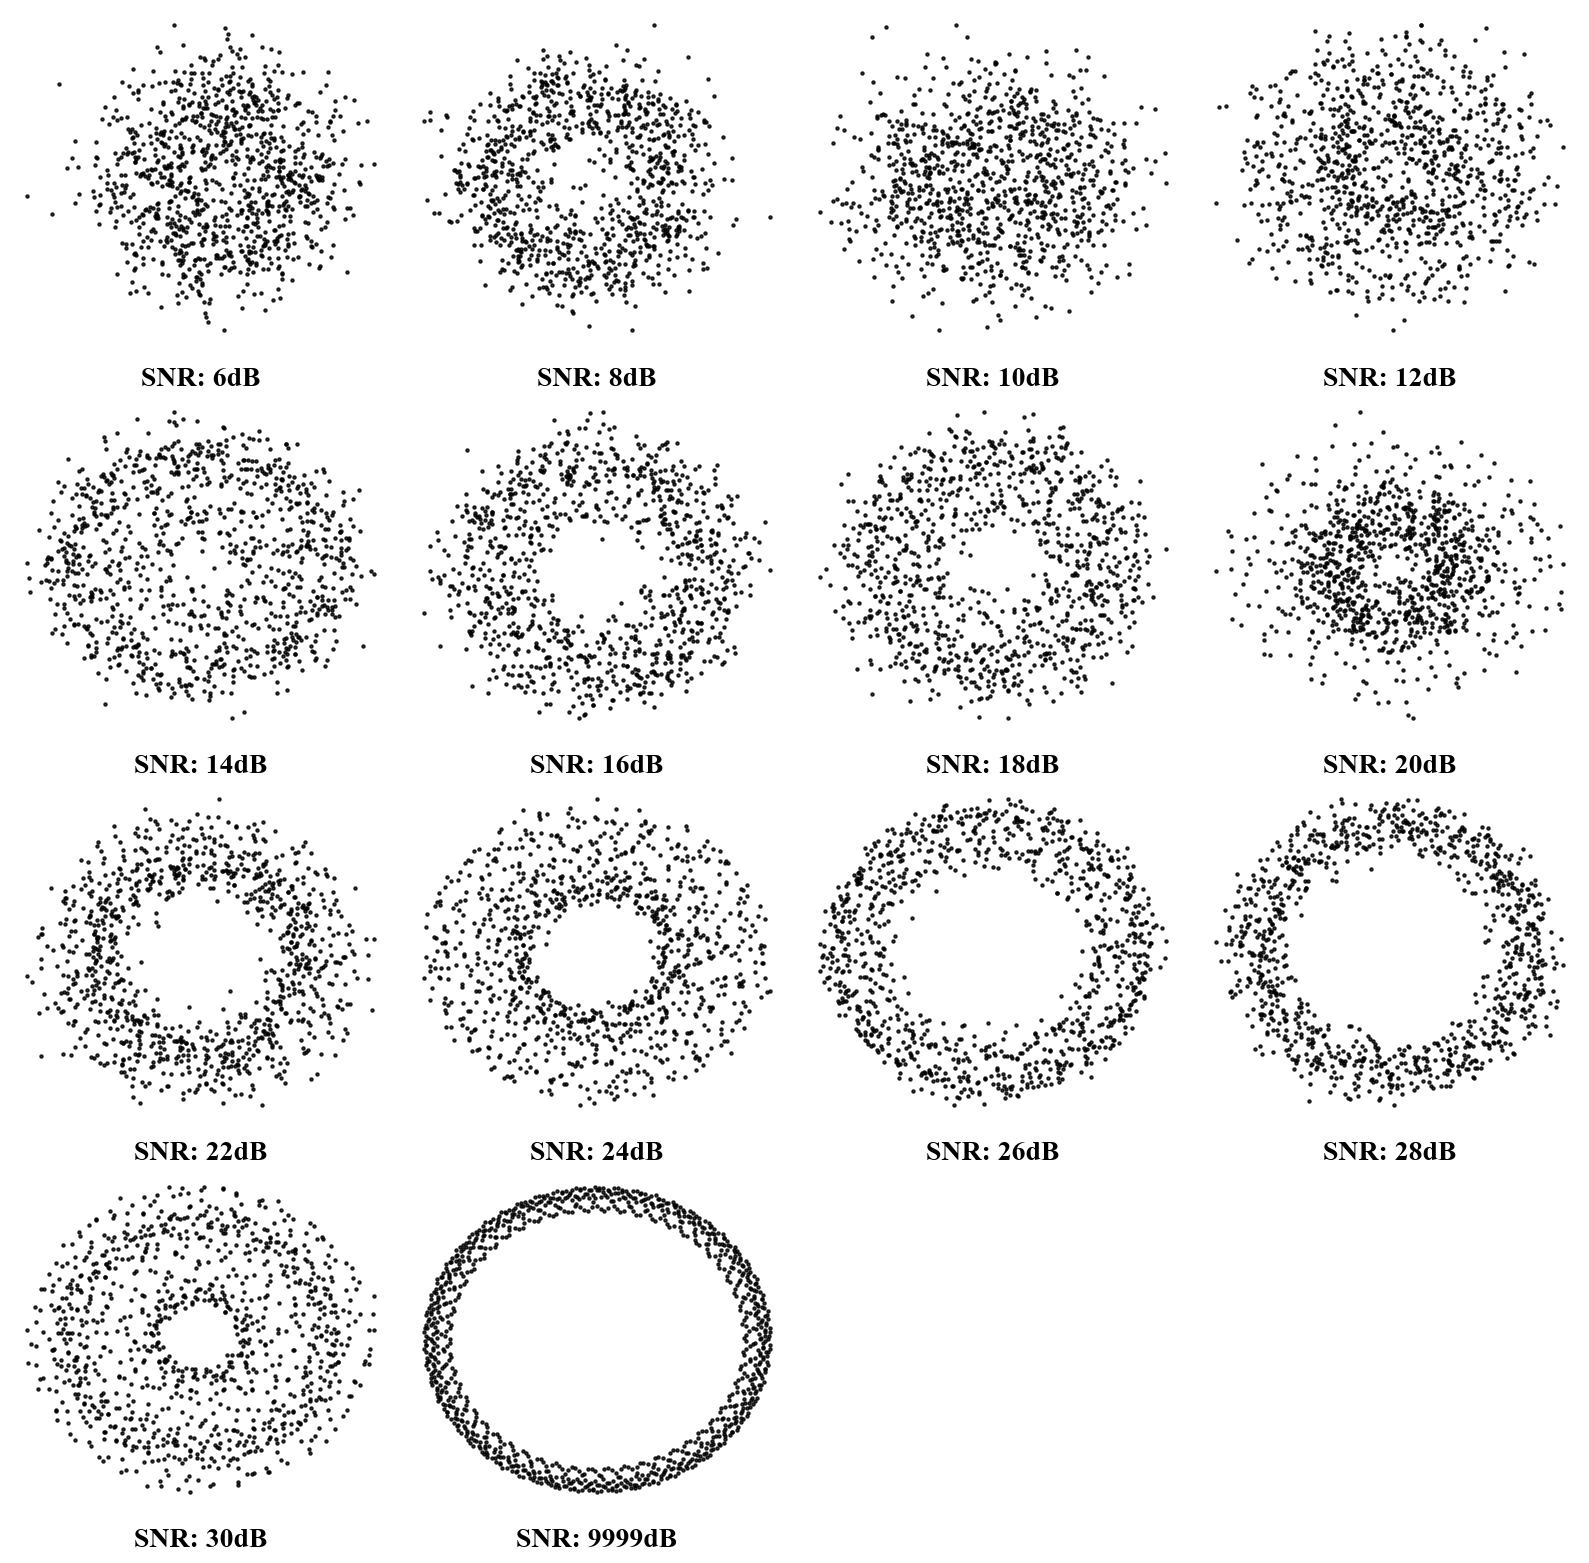

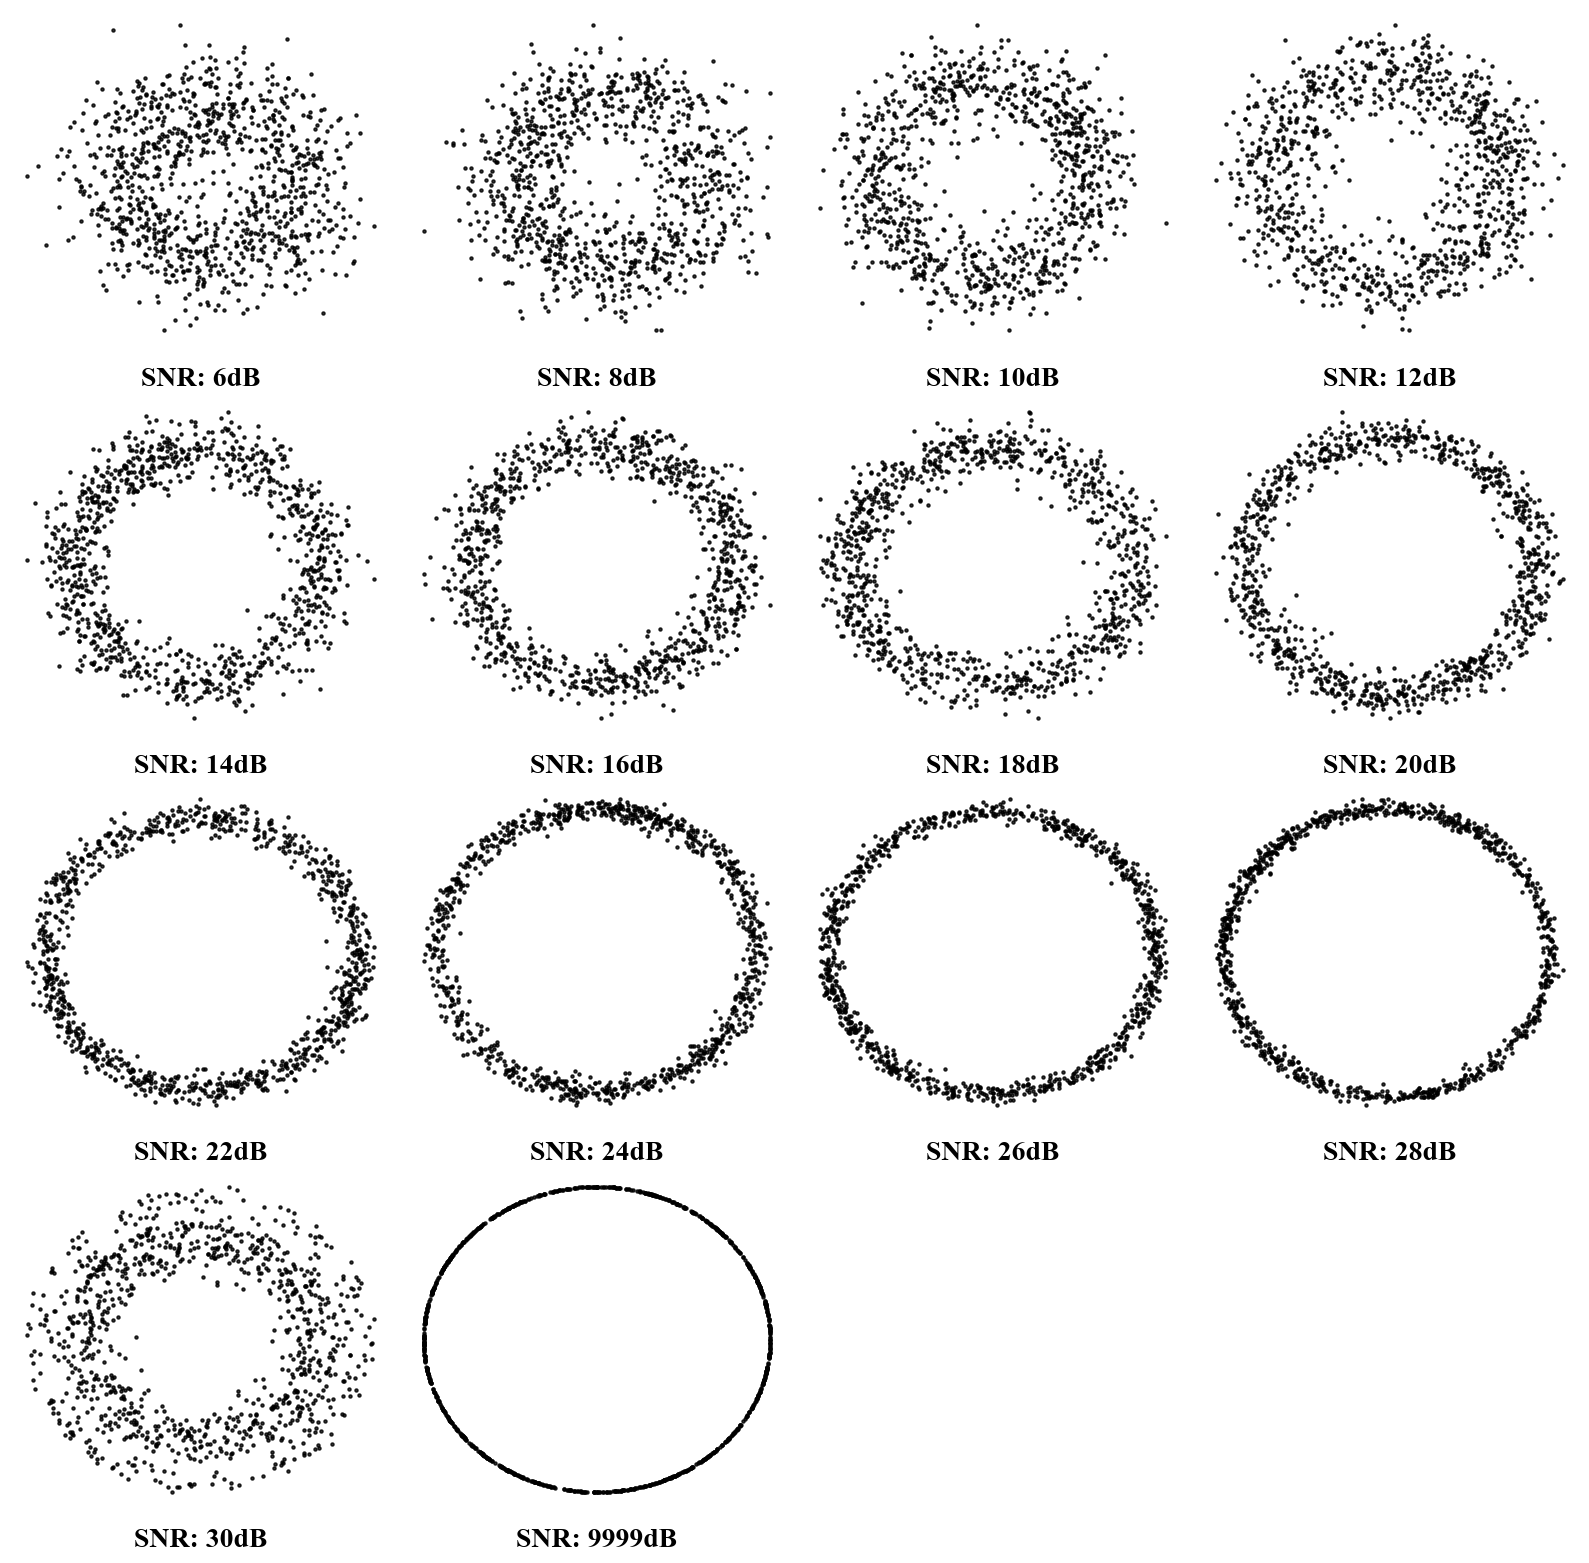

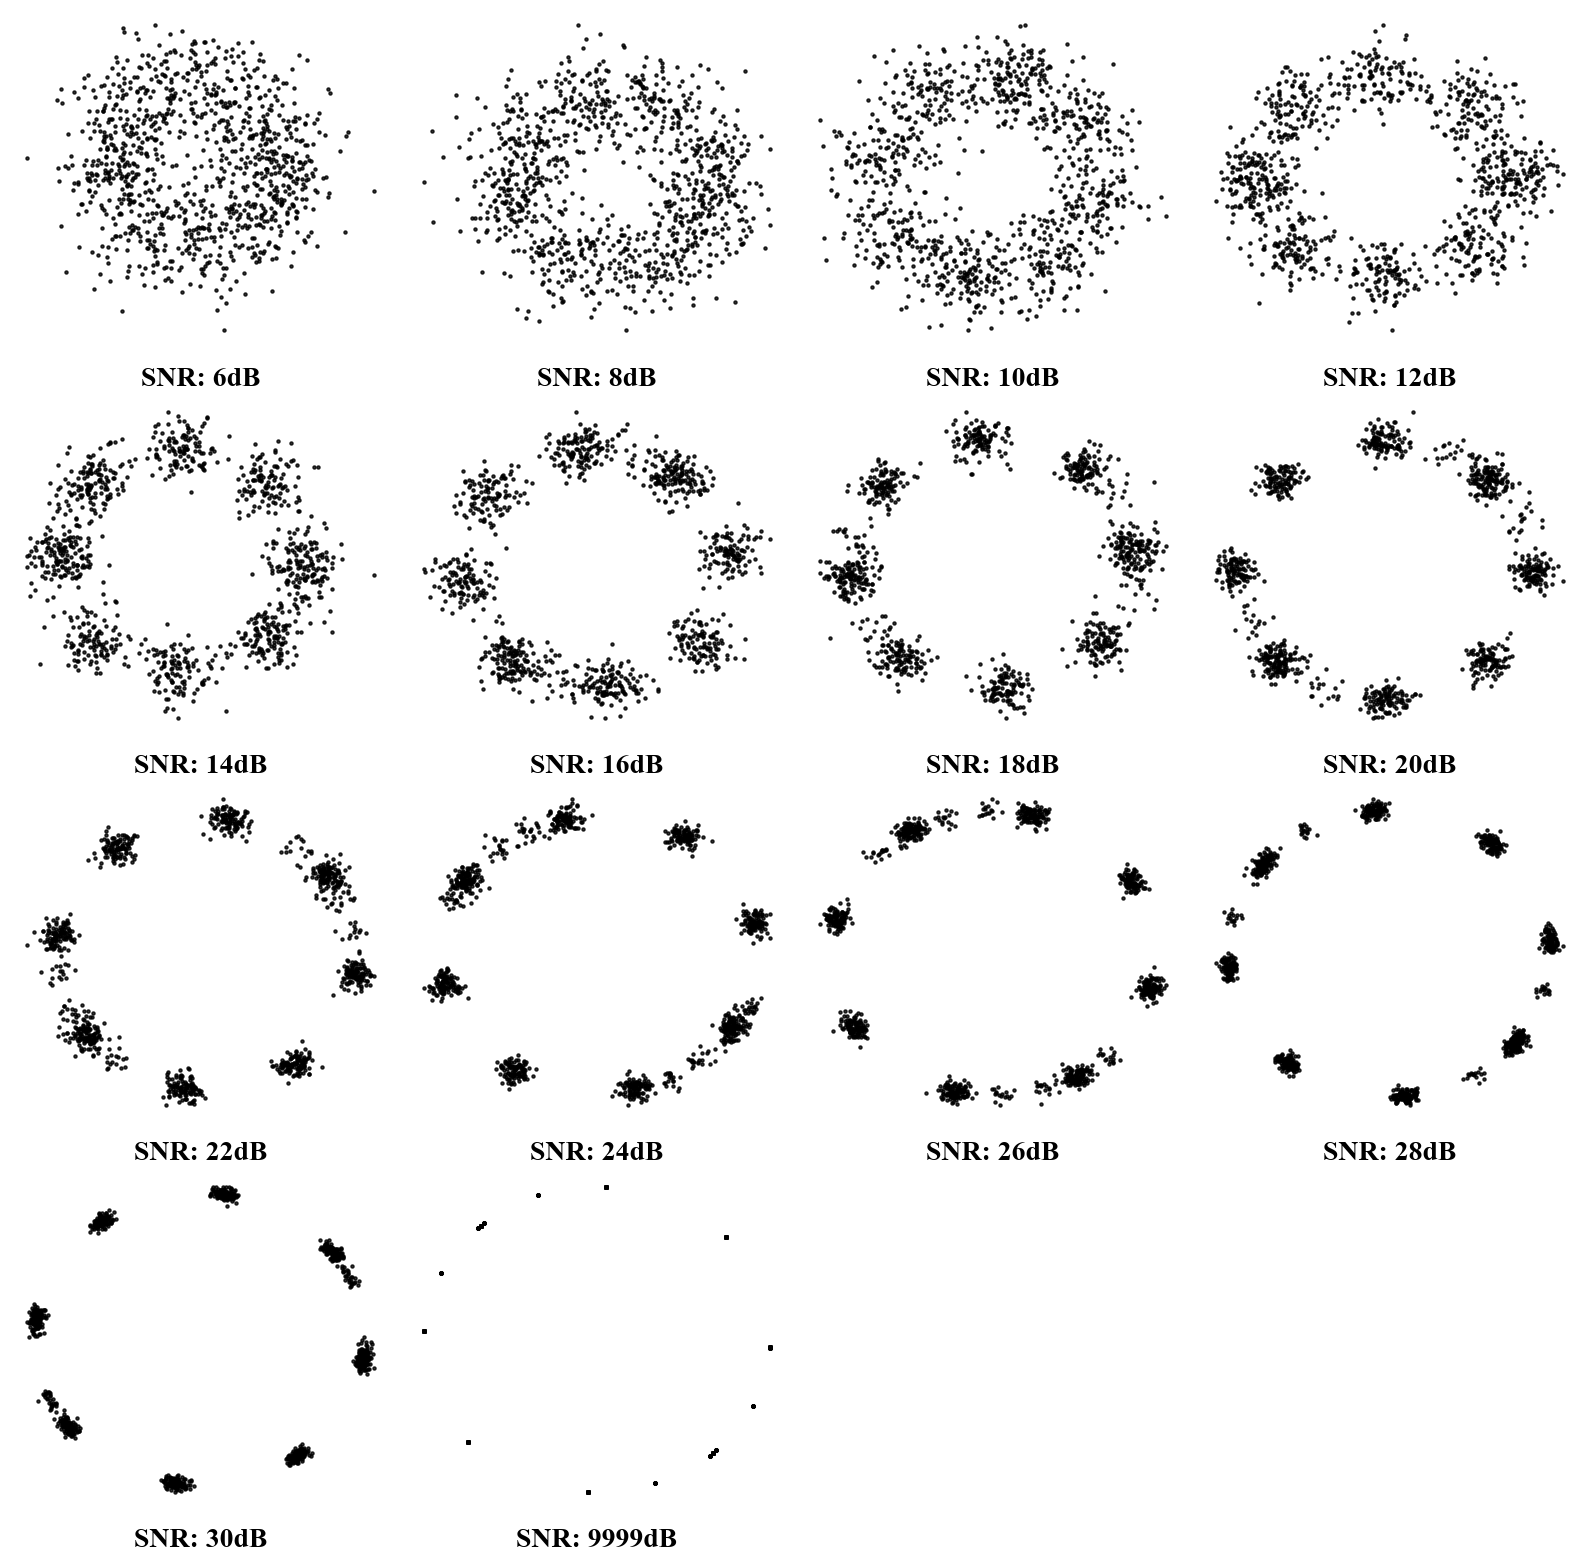

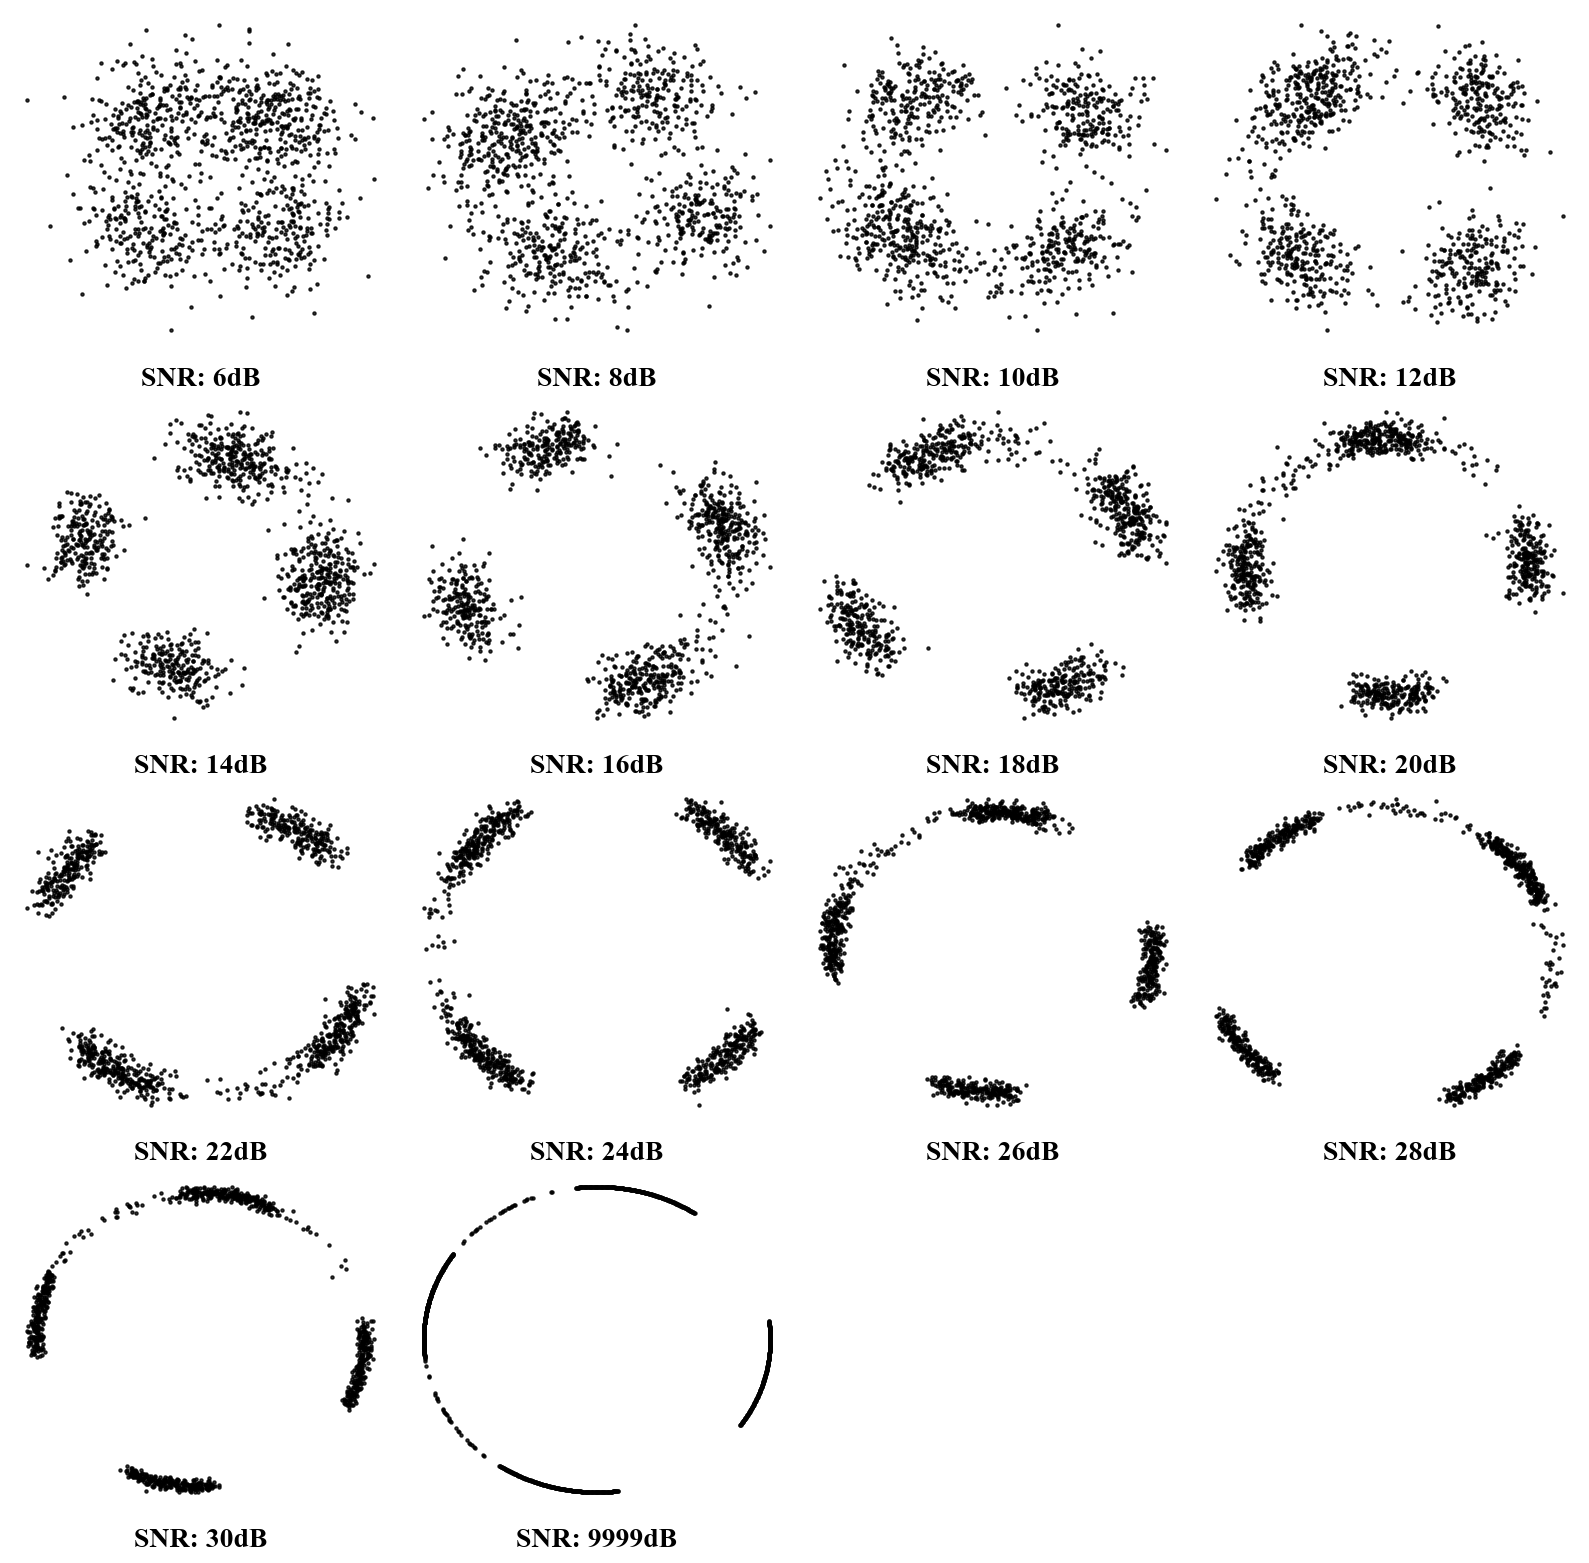

In [7]:
for modulation in range(10):
    plot_constellation_snr_levels(modulation, classes, X, Y, Z)

In [1]:
directory = ".\\train_tuned_final\\ray_results\\train_model_2025-02-13_02-42-12"

# loop through this directory and inside each directory, loop through the files and get the progress.csv

import os
import pandas as pd
import json

dirs = os.listdir(directory)
# go through each directory and get the progress.csv file
results = []
for dir in dirs:
    if os.path.isdir(os.path.join(directory, dir)):
        for root, dirs, files in os.walk(os.path.join(directory, dir)):
            for file in files:
                if file == "progress.csv":
                    df = pd.read_csv(os.path.join(root, file))

                    val_loss = df["val_loss"].tolist()
                    # convert the column to list
                    train_loss = df["train_loss"].tolist()
                    training_iteration = df["training_iteration"].values[-1]
                elif file == "params.json":
                    df = json.load(open(os.path.join(root, file)))
                    drop_rate = df["drop_factor"]
                    learning_rate = df["learning_rate"]
                    l_2 = df["l_2"]
                    l_1 = df["l_1"]

            results.append({
                "val_loss": val_loss,
                "train_loss": train_loss,
                "training_iteration": training_iteration,
                "drop_rate": drop_rate,
                "learning_rate": learning_rate,
                "l_2": l_2,
                "l_1": l_1,
                "directory": root
            })


In [ ]:
plots_per_page = 6  # 2 rows * 3 columns
total_plots = len(results)
num_pages = (total_plots + plots_per_page - 1) // plots_per_page  # Calculate the number of pages needed

for page in range(num_pages):
    plt.figure(figsize=(24, 16))
    start_idx = page * plots_per_page
    end_idx = min(start_idx + plots_per_page, total_plots)
    
    for i, result in enumerate(results[start_idx:end_idx], start=1):
        if len(result["val_loss"]) < 2:
            continue
        
        ax = plt.subplot(2, 3, i)
        ax.plot(result["val_loss"], label="Validation Loss", linestyle='--', linewidth=1, color="black")
        ax.plot(result["train_loss"], label="Training Loss", linewidth=1, color="black")
        ax.legend(fontsize=20)
        ax.set_title(
            r'$d_{\text{drop}}$: ' + f"{result['drop_rate']}, " +
            r'$\alpha_{\text{lr}}$: ' + f"{result['learning_rate']:.5f}, " +
            r'$\lambda_{\text{L1}}$: ' + f"{result['l_1']}",
            fontsize=20
        )
        ax.set_xlabel("Epoch", fontsize=20)
        ax.set_ylabel("Loss", fontsize=20)
        ax.axis('on')
        ax.set_xticks(range(1, result["training_iteration"]))
        ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.tight_layout()
    plt.savefig(f"./visualization/loss_tuned_final_page_{page + 1}.pdf", format="pdf")
    plt.close()

plt.show()


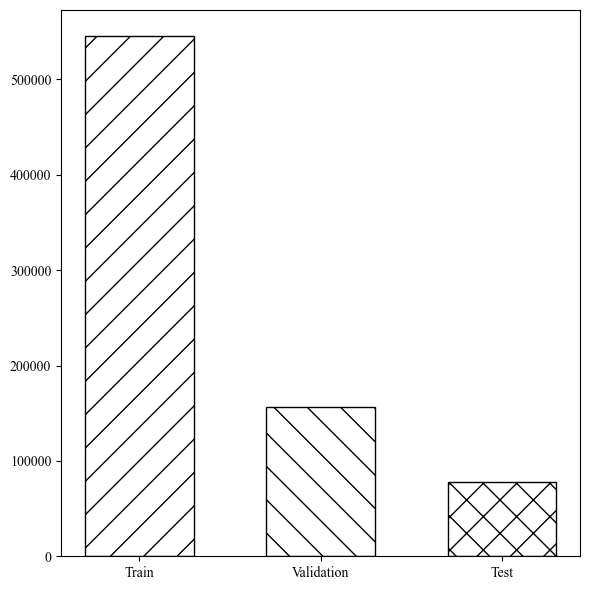

In [70]:


datasets = np.load('./arrays/datasets.npy')
counts = np.load('./arrays/counts.npy')

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.6
ax.bar(datasets, counts, width=bar_width, color='white', edgecolor='black', hatch=['/', '\\', 'x'])

# Aesthetic improvements
# ax.set_title("Sample Counts in Train, Validation, and Test Sets", fontsize=14)
# ax.set_xlabel("Dataset")
# ax.set_ylabel("Count")

plt.savefig("./visualization/dataset_dist.pdf", format="pdf")
plt.tight_layout()
plt.show()

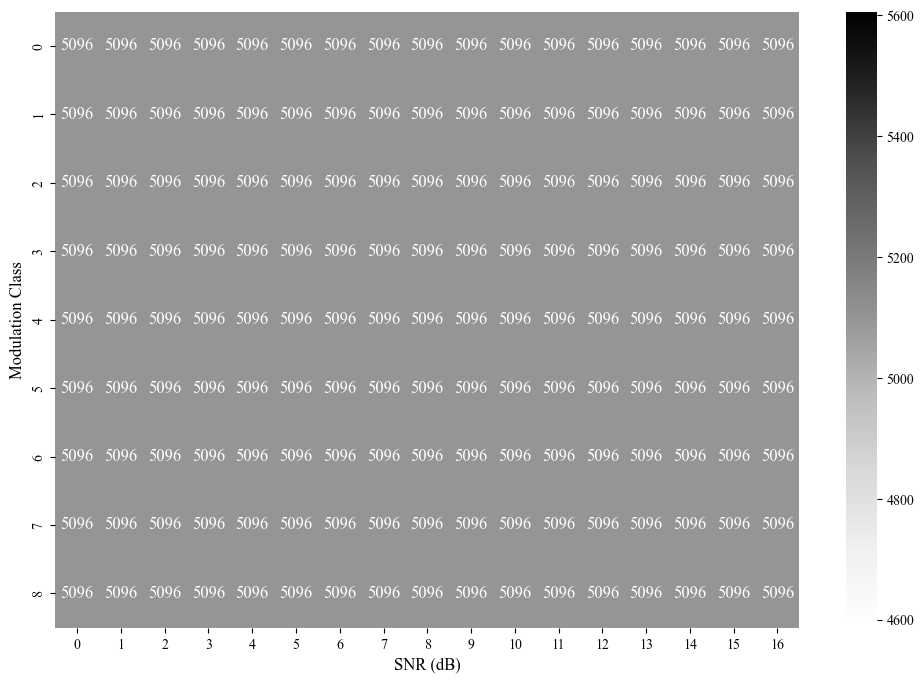

In [14]:

df_heatmap = np.load('./arrays/heatmap.npy')
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, cmap="Greys", fmt="g", annot_kws={"size": 12})
# plt.title("Modulation Class vs SNR Heatmap (Instance Counts)")
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Modulation Class", fontsize=12)
plt.savefig("./visualization/snr_class_count.pdf", format="pdf")

plt.show()

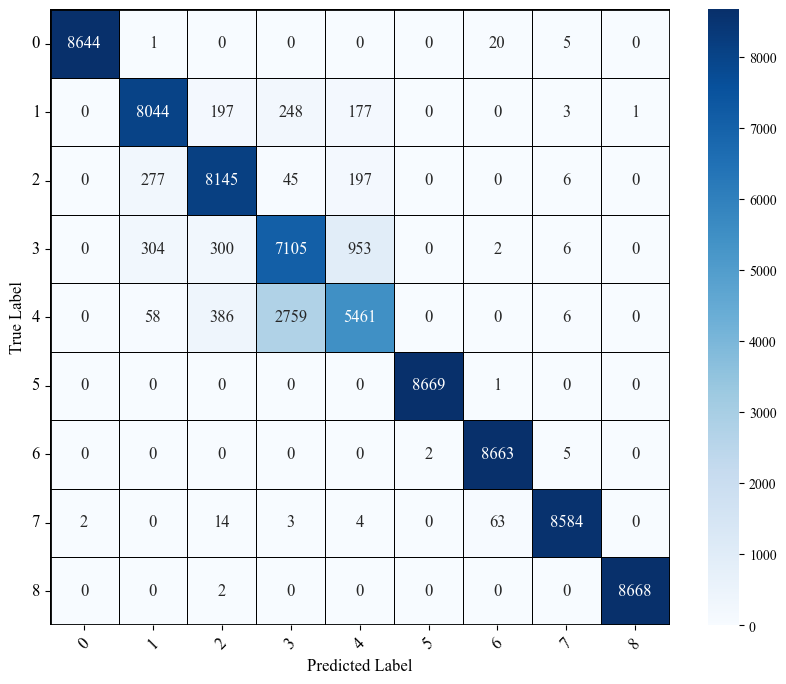

In [23]:
########################################### BATCH 16 ###########################################

num_classes = 9
all_labels = np.load('./arrays/b_16/all_labels.npy')
all_preds = np.load('./arrays/b_16/all_preds.npy')
all_probs = np.load('./arrays/b_16/all_probs.npy')

conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', annot_kws={"size": 12})

# Add border to all four corners
ax.add_patch(patches.Rectangle((0, 0), num_classes, num_classes, fill=False, edgecolor='black', lw=2))

# Customize labels
plt.xticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=45, fontsize=12)
plt.yticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=0, fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)


# Save the plot
plt.savefig('./visualization/confusion_matrix_b16.pdf', format='pdf', bbox_inches='tight')



# Show the plot
plt.show()

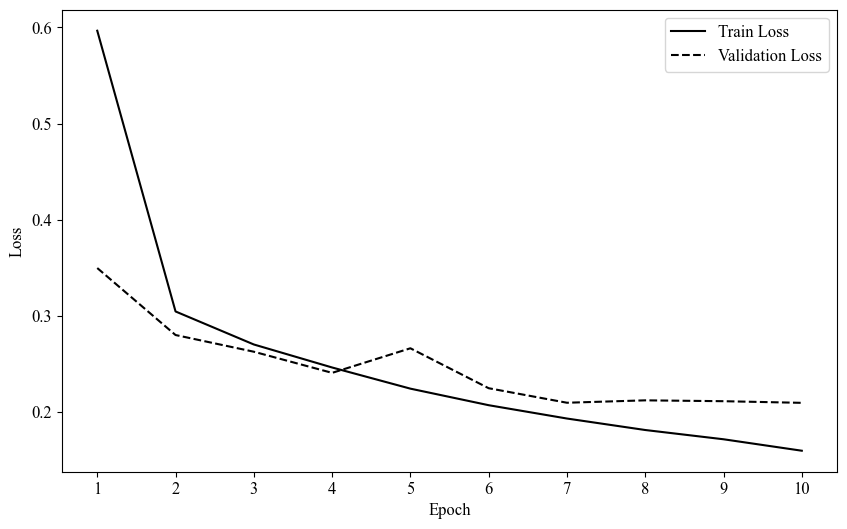

In [67]:
train_loss_history = np.load('./train_b16/checkpoints/train_loss_history.npy')
val_loss_history = np.load('./train_b16/checkpoints/val_loss_history.npy')

# plot of train and validation loss in same graph using sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig('./visualization/loss_b16.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [20]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

Precision: 92.40
Recall: 92.25
F1 Score: 92.15
Accuracy: 92.25


In [21]:
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK'
]

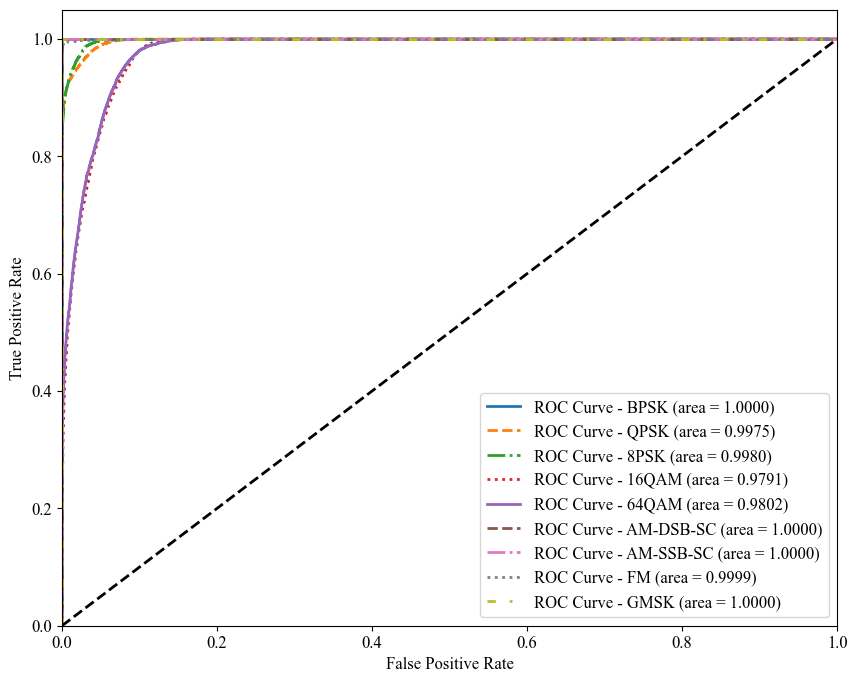

In [24]:
fpr  = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC Curve - {classes[i]} (area = {roc_auc[i]:.4f})',linestyle=line_styles[i % len(line_styles)])
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=12)
plt.savefig('./visualization/roc_curve_b16.pdf', format='pdf', bbox_inches='tight')

plt.show()

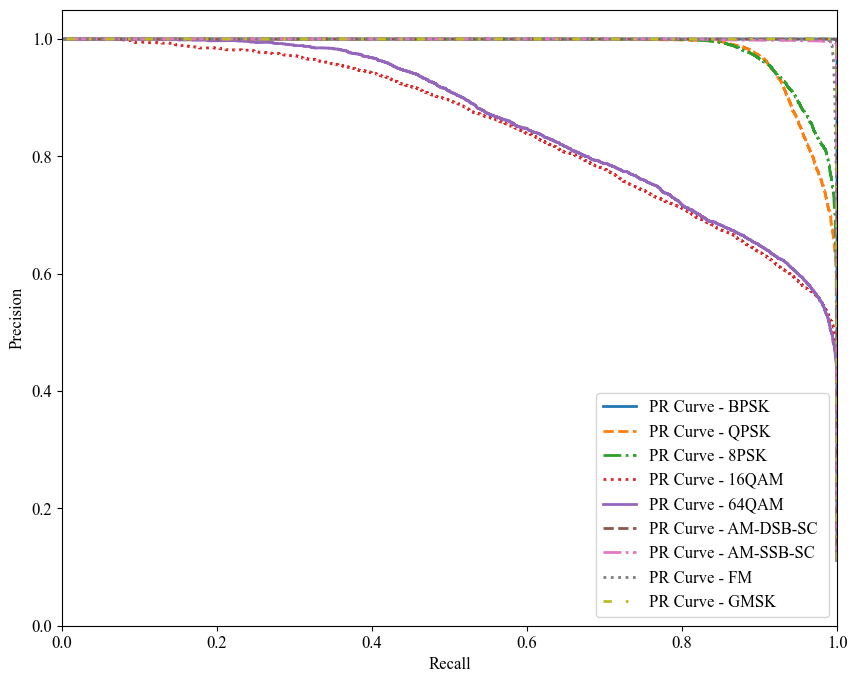

In [70]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    average_precision[i] = np.average(precision[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2,label=f'PR Curve - {classes[i]} ', linestyle=line_styles[i % len(line_styles)])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
# plt.title('Precision-Recall Curve')
plt.savefig('./visualization/precision_recall_curve_b16.pdf', format='pdf')
plt.show()

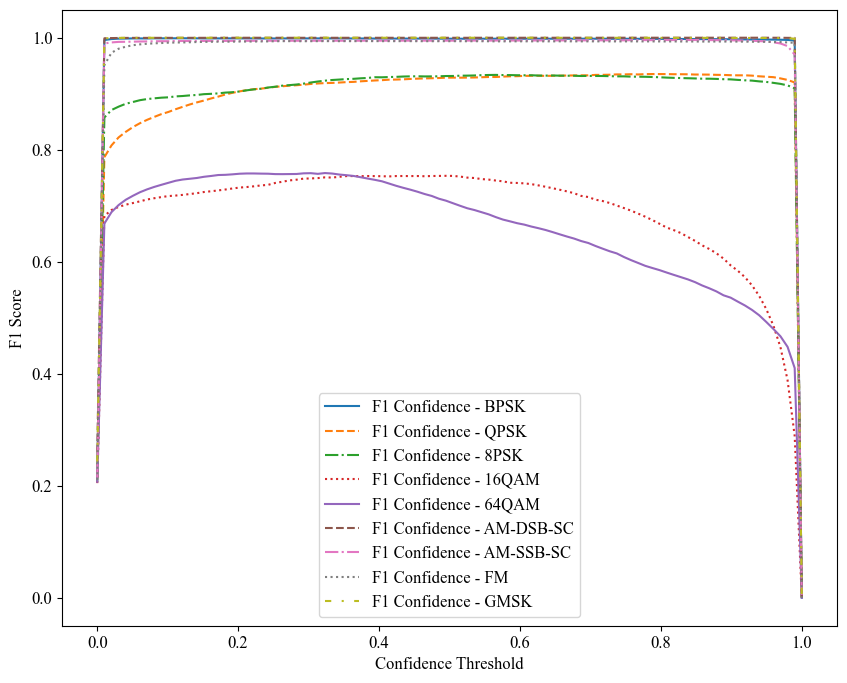

In [71]:
# f1 score vs confidence threshold
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1_scores = np.zeros((num_classes, len(thresholds)))

for i, threshold in enumerate(thresholds):
    for j in range(num_classes):
        preds = all_probs[:, j] > threshold
        f1_scores[j, i] = f1_score(all_labels == j, preds)

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}', linestyle=line_styles[i % len(line_styles)])
    plt.legend(loc="best", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Confidence Threshold', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.savefig('./visualization/f1_score_b16.pdf', format='pdf', bbox_inches='tight')
plt.show()

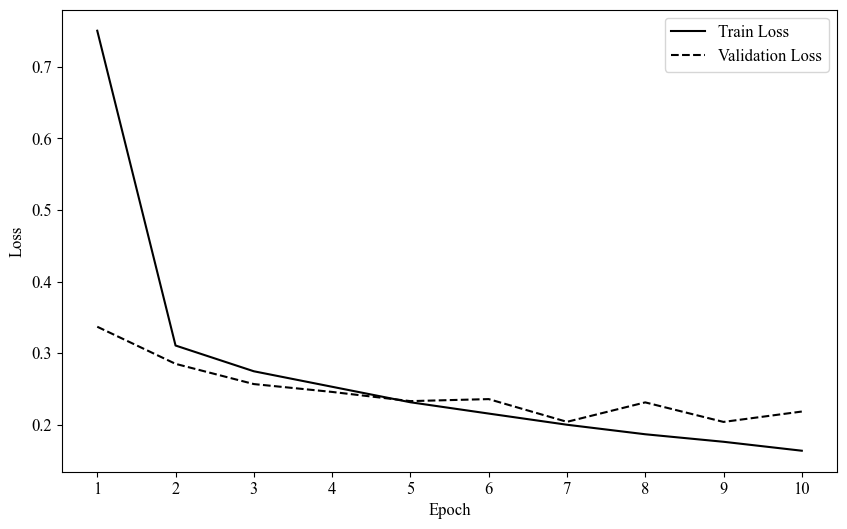

In [5]:
############################## BATCH 32 ###########################################
train_loss_history = np.load('./train_b32/checkpoints/train_loss_history.npy')
val_loss_history = np.load('./train_b32/checkpoints/val_loss_history.npy')

# plot of train and validation loss in same graph using sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.savefig('./visualization/loss_b32.pdf', format='pdf', bbox_inches='tight')
plt.show()


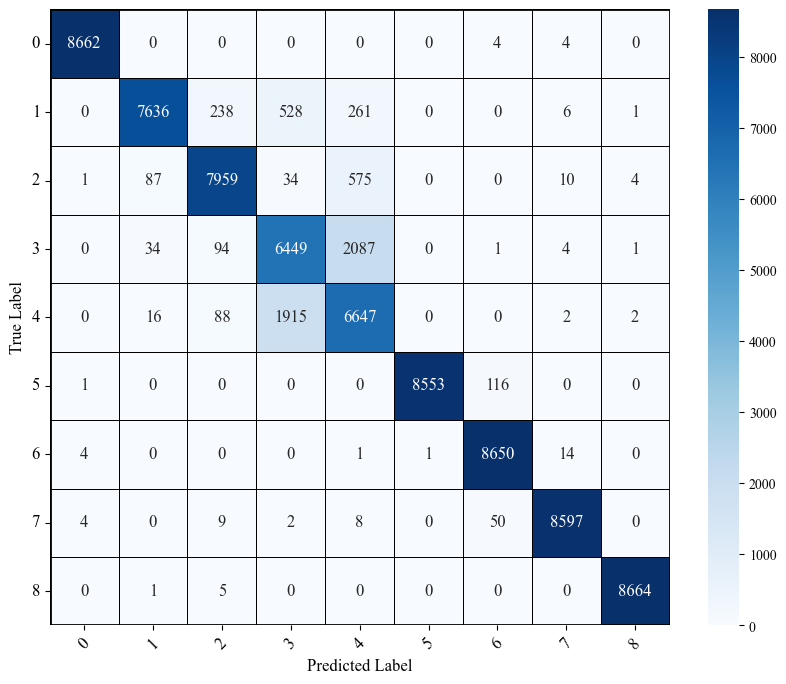

In [19]:
########################################### BATCH 16 ###########################################

num_classes = 9
all_labels = np.load('./arrays/b_32/all_labels.npy')
all_preds = np.load('./arrays/b_32/all_preds.npy')
all_probs = np.load('./arrays/b_32/all_probs.npy')

conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', annot_kws={"size": 12})

# Add border to all four corners
ax.add_patch(patches.Rectangle((0, 0), num_classes, num_classes, fill=False, edgecolor='black', lw=2))

# Customize labels
plt.xticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=45, fontsize=12)
plt.yticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=0, fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Save the plot
plt.savefig('./visualization/confusion_matrix_b32.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

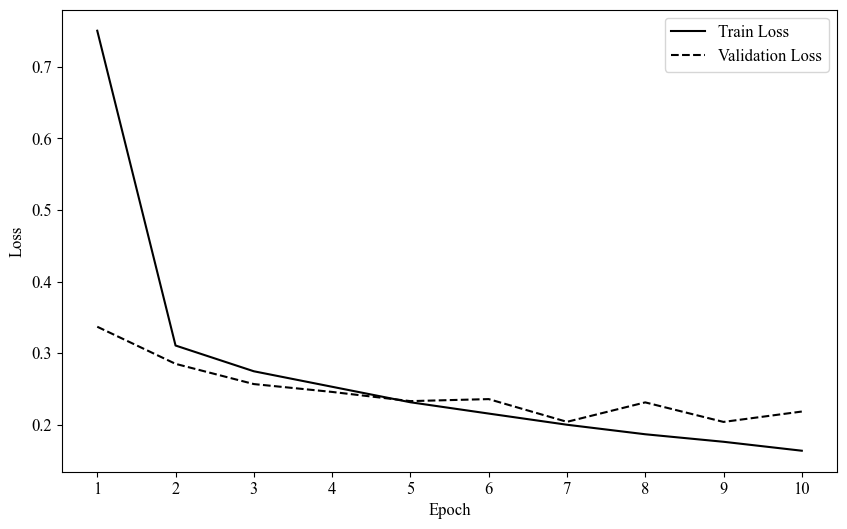

In [75]:
train_loss_history = np.load('./train_b32/checkpoints/train_loss_history.npy')
val_loss_history = np.load('./train_b32/checkpoints/val_loss_history.npy')

# plot of train and validation loss in same graph using sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.savefig('./visualization/loss_b32.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [28]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

Precision: 92.45
Recall: 92.04
F1 Score: 92.19
Accuracy: 92.04


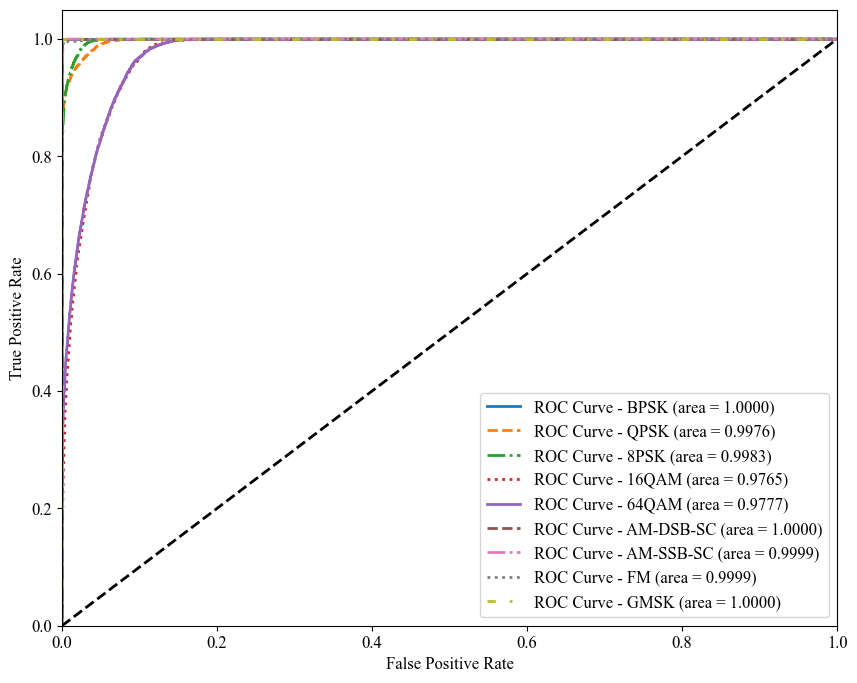

In [20]:
fpr  = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC Curve - {classes[i]} (area = {roc_auc[i]:.4f})',  linestyle=line_styles[i % len(line_styles)])
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=12)
plt.savefig('./visualization/roc_curve_b32.pdf', format='pdf', bbox_inches='tight')
plt.show()

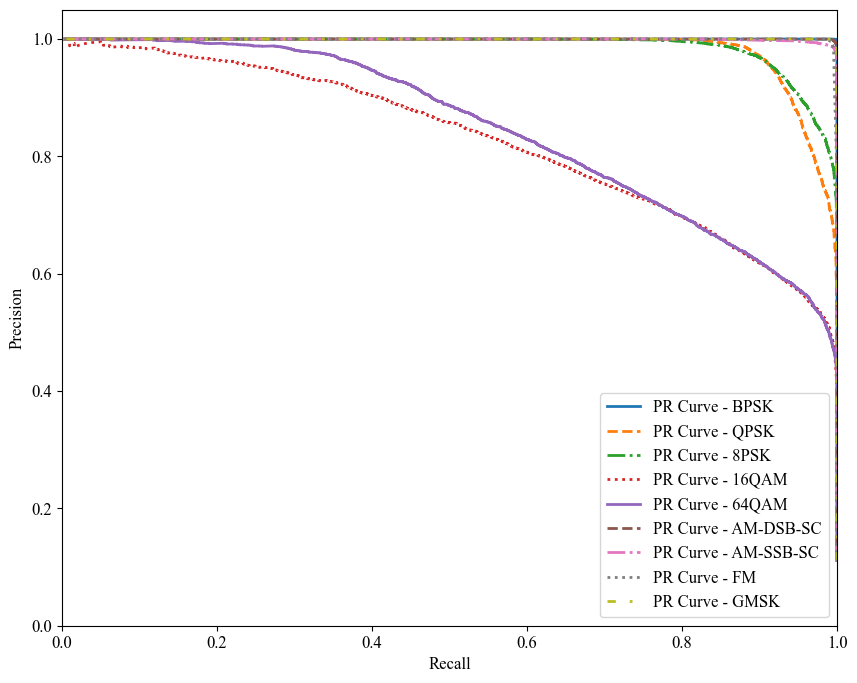

In [77]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    average_precision[i] = np.average(precision[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i] ,lw=2,label=f'PR Curve - {classes[i]}', linestyle=line_styles[i % len(line_styles)])
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall', fontsize=12) 
plt.ylabel('Precision', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
# plt.title('Precision-Recall Curve')
plt.savefig('./visualization/precision_recall_curve_b32.pdf', format='pdf')
plt.show()

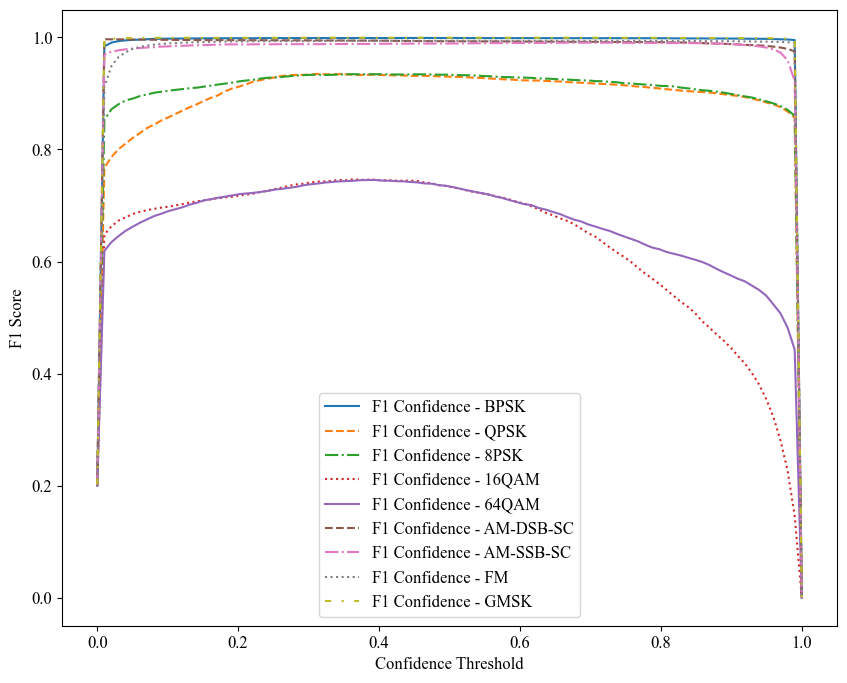

In [78]:
# # f1 score vs confidence threshold
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 100)
# f1_scores = np.zeros((num_classes, len(thresholds)))

# for i, threshold in enumerate(thresholds):
#     for j in range(num_classes):
#         preds = all_probs[:, j] > threshold
#         f1_scores[j, i] = f1_score(all_labels == j, preds)

# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}')
#     plt.legend(loc="best", fontsize=12)
#     plt.xlabel('Confidence Threshold')
#     plt.ylabel('F1 Score')
#     plt.savefig('./visualization/f1_score_b32.pdf', format='pdf', bbox_inches='tight')
# plt.show()

thresholds = np.linspace(0, 1, 100)
f1_scores = np.zeros((num_classes, len(thresholds)))

for i, threshold in enumerate(thresholds):
    for j in range(num_classes):
        preds = all_probs[:, j] > threshold
        f1_scores[j, i] = f1_score(all_labels == j, preds)

# Define 9 different line styles
line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}', linestyle=line_styles[i % len(line_styles)])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.savefig('./visualization/f1_score_b32.pdf', format='pdf', bbox_inches='tight')
plt.show()

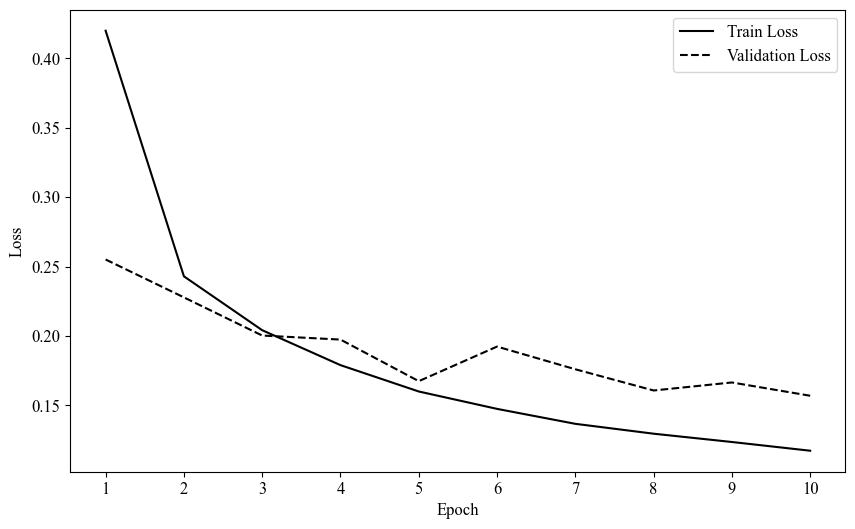

In [5]:
train_loss_history = np.load('./train_tuned/checkpoints/train_loss_history.npy')
val_loss_history = np.load('./train_tuned/checkpoints/val_loss_history.npy')

# plot of train and validation loss in same graph using sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.savefig('./visualization/loss_tuned.pdf', format='pdf', bbox_inches='tight')
plt.show()


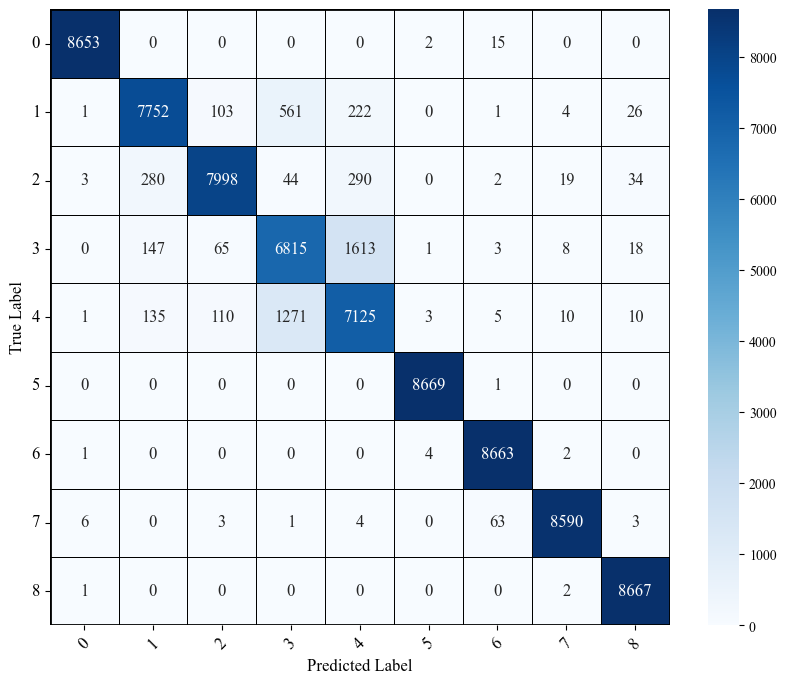

In [21]:
########################################### BATCH 16 ###########################################

num_classes = 9
all_labels = np.load('./arrays/tuned/all_labels.npy')
all_preds = np.load('./arrays/tuned/all_preds.npy')
all_probs = np.load('./arrays/tuned/all_probs.npy')

conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', annot_kws={"size": 12})

# Add border to all four corners
ax.add_patch(patches.Rectangle((0, 0), num_classes, num_classes, fill=False, edgecolor='black', lw=2))

# Customize labels
plt.xticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=45, fontsize=12)
plt.yticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=0, fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Save the plot
plt.savefig('./visualization/confusion_matrix_tuned.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [14]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

Precision: 93.60
Recall: 93.47
F1 Score: 93.51
Accuracy: 93.47


In [15]:
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK'
]

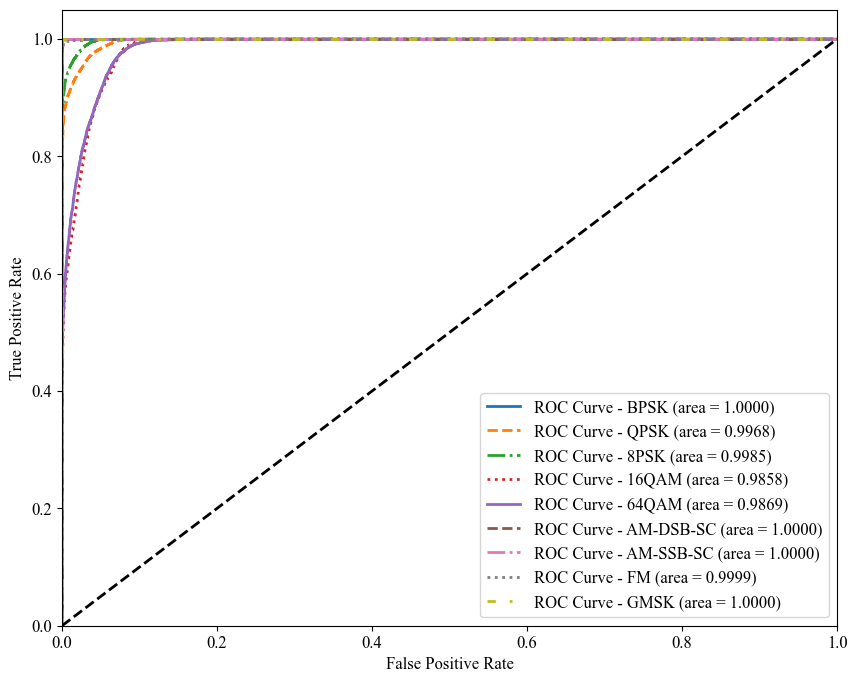

In [22]:
fpr  = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC Curve - {classes[i]} (area = {roc_auc[i]:.4f})',  linestyle=line_styles[i % len(line_styles)])
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=12)
plt.savefig('./visualization/roc_curve_tuned.pdf', format='pdf', bbox_inches='tight')

plt.show()

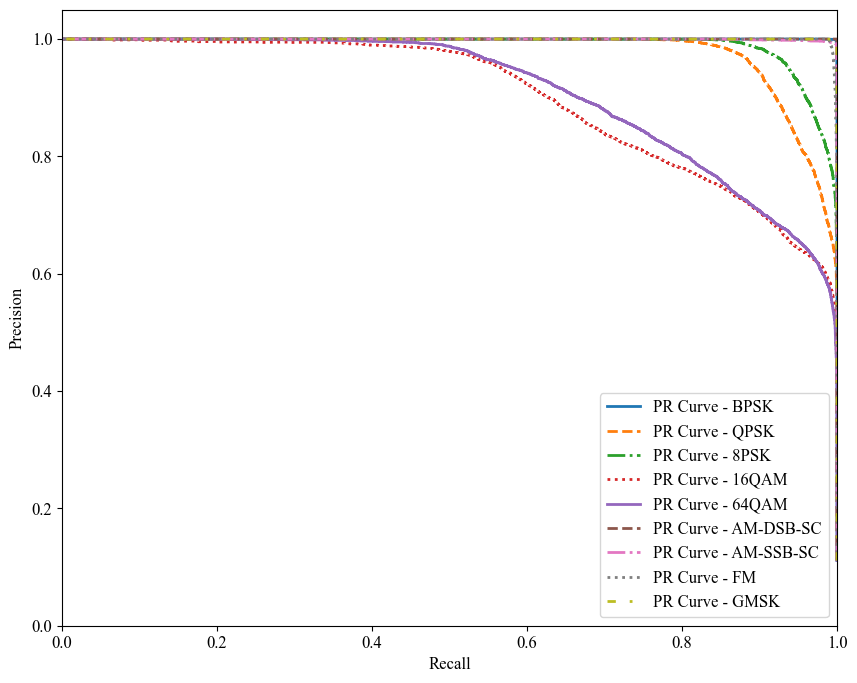

In [17]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    average_precision[i] = np.average(precision[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i] ,lw=2,label=f'PR Curve - {classes[i]}', linestyle=line_styles[i % len(line_styles)])
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall', fontsize=12) 
plt.ylabel('Precision', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
# plt.title('Precision-Recall Curve')
plt.savefig('./visualization/precision_recall_curve_tuned.pdf', format='pdf')
plt.show()

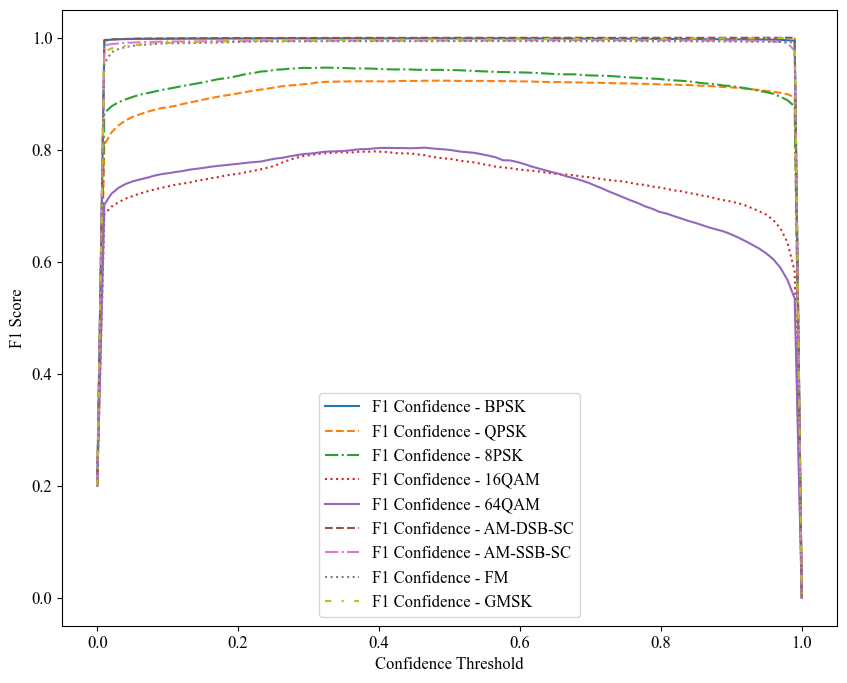

In [18]:
# # f1 score vs confidence threshold
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 100)
# f1_scores = np.zeros((num_classes, len(thresholds)))

# for i, threshold in enumerate(thresholds):
#     for j in range(num_classes):
#         preds = all_probs[:, j] > threshold
#         f1_scores[j, i] = f1_score(all_labels == j, preds)

# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}')
#     plt.legend(loc="best", fontsize=12)
#     plt.xlabel('Confidence Threshold')
#     plt.ylabel('F1 Score')
#     plt.savefig('./visualization/f1_score_b32.pdf', format='pdf', bbox_inches='tight')
# plt.show()

thresholds = np.linspace(0, 1, 100)
f1_scores = np.zeros((num_classes, len(thresholds)))

for i, threshold in enumerate(thresholds):
    for j in range(num_classes):
        preds = all_probs[:, j] > threshold
        f1_scores[j, i] = f1_score(all_labels == j, preds)

# Define 9 different line styles
line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}', linestyle=line_styles[i % len(line_styles)])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.savefig('./visualization/f1_score_tuned.pdf', format='pdf', bbox_inches='tight')
plt.show()

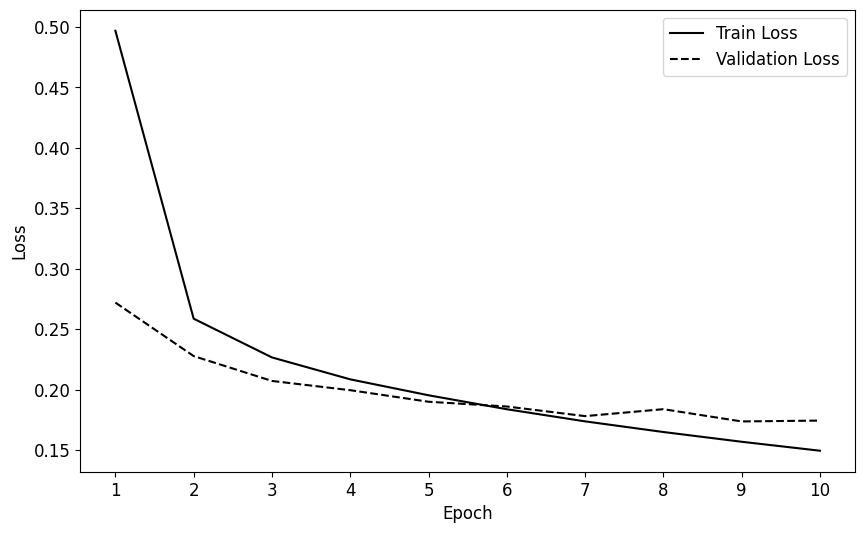

In [3]:
train_loss_history = np.load('./new_tuned/train_loss_history.npy')
val_loss_history = np.load('./new_tuned/val_loss_history.npy')

# plot of train and validation loss in same graph using sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.savefig('./visualization/loss_new_tuned.pdf', format='pdf', bbox_inches='tight')
plt.show()


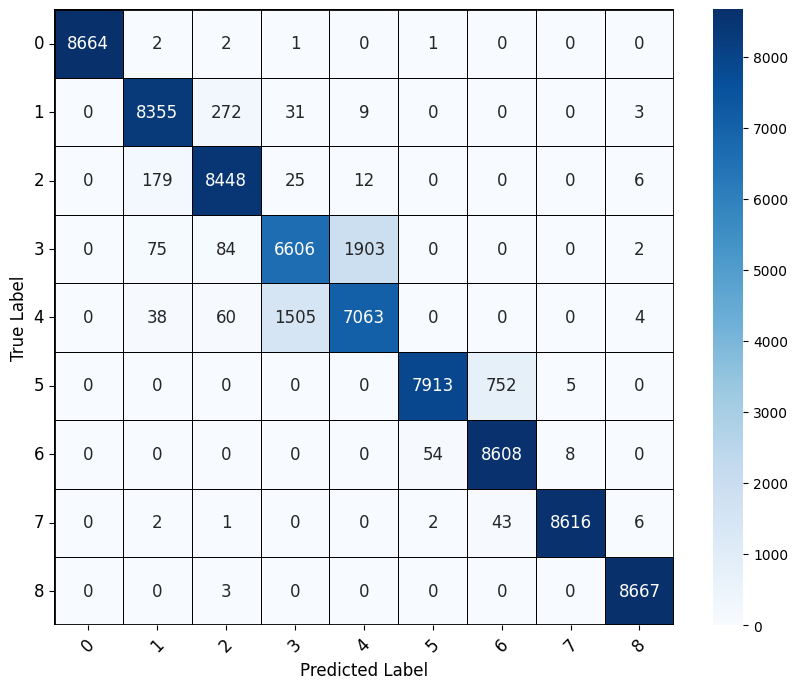

In [4]:
########################################### BATCH 16 ###########################################

num_classes = 9
all_labels = np.load('./arrays/new_tuned/all_labels.npy')
all_preds = np.load('./arrays/new_tuned/all_preds.npy')
all_probs = np.load('./arrays/new_tuned/all_probs.npy')

conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black', annot_kws={"size": 12})

# Add border to all four corners
ax.add_patch(patches.Rectangle((0, 0), num_classes, num_classes, fill=False, edgecolor='black', lw=2))

# Customize labels
plt.xticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=45, fontsize=12)
plt.yticks(np.arange(num_classes) + 0.5, range(num_classes), rotation=0, fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Save the plot
plt.savefig('./visualization/confusion_matrix_new_tuned.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [5]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

Precision: 93.53
Recall: 93.48
F1 Score: 93.45
Accuracy: 93.48


In [6]:
classes = [
    'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'AM-DSB-SC', 'AM-SSB-SC', 'FM', 'GMSK'
]

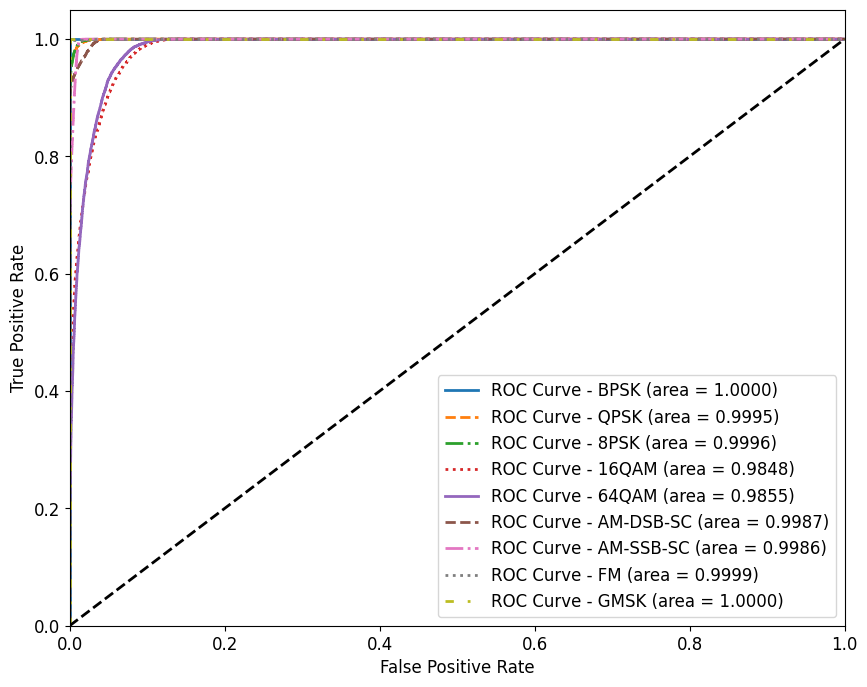

In [7]:
fpr  = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC Curve - {classes[i]} (area = {roc_auc[i]:.4f})',  linestyle=line_styles[i % len(line_styles)])
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=12)
plt.savefig('./visualization/roc_curve_new_tuned.pdf', format='pdf', bbox_inches='tight')

plt.show()

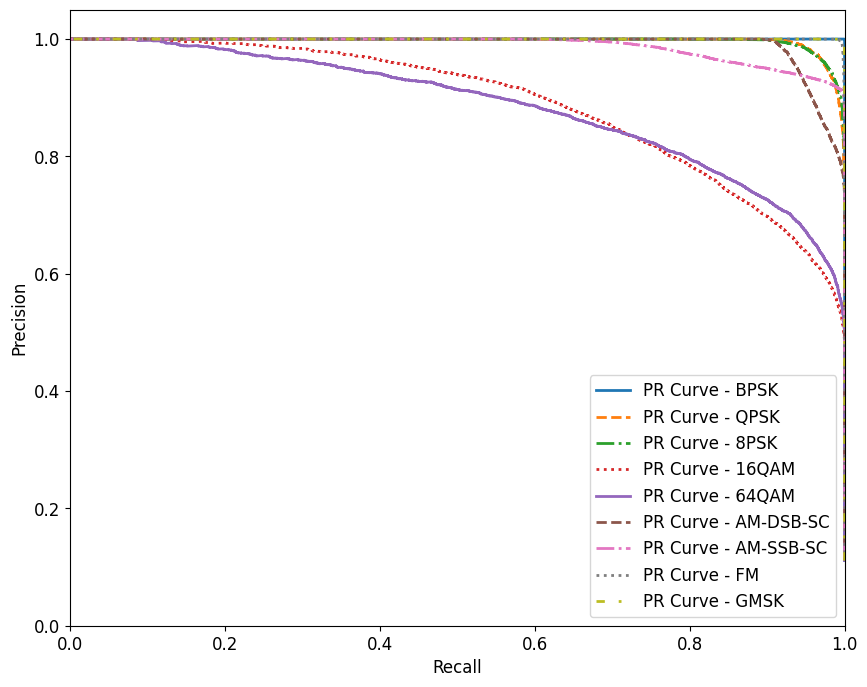

In [8]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    average_precision[i] = np.average(precision[i])

line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i] ,lw=2,label=f'PR Curve - {classes[i]}', linestyle=line_styles[i % len(line_styles)])
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall', fontsize=12) 
plt.ylabel('Precision', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
# plt.title('Precision-Recall Curve')
plt.savefig('./visualization/precision_recall_curve_new_tuned.pdf', format='pdf')
plt.show()

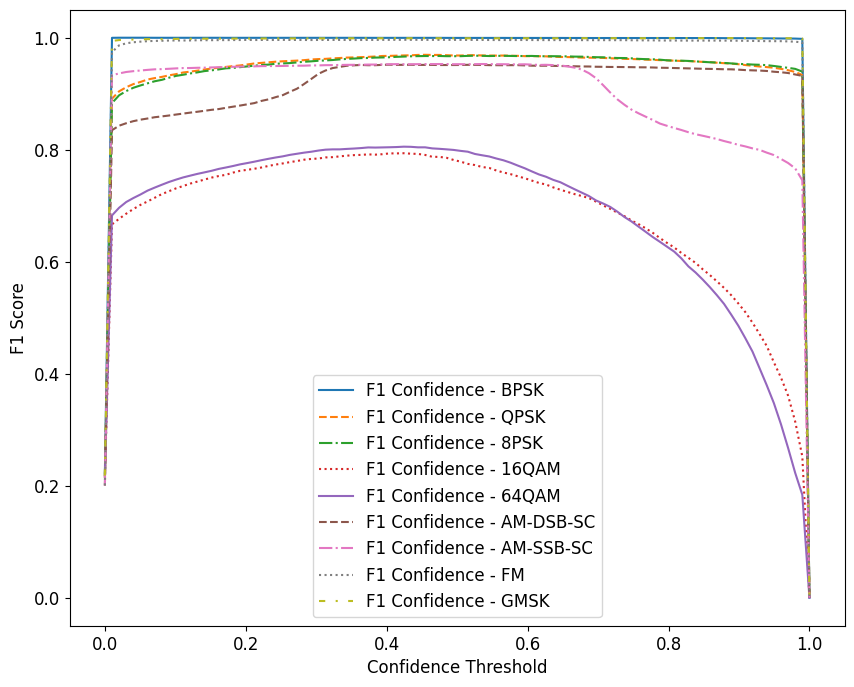

In [9]:
# # f1 score vs confidence threshold
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 100)
# f1_scores = np.zeros((num_classes, len(thresholds)))

# for i, threshold in enumerate(thresholds):
#     for j in range(num_classes):
#         preds = all_probs[:, j] > threshold
#         f1_scores[j, i] = f1_score(all_labels == j, preds)

# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}')
#     plt.legend(loc="best", fontsize=12)
#     plt.xlabel('Confidence Threshold')
#     plt.ylabel('F1 Score')
#     plt.savefig('./visualization/f1_score_b32.pdf', format='pdf', bbox_inches='tight')
# plt.show()

thresholds = np.linspace(0, 1, 100)
f1_scores = np.zeros((num_classes, len(thresholds)))

for i, threshold in enumerate(thresholds):
    for j in range(num_classes):
        preds = all_probs[:, j] > threshold
        f1_scores[j, i] = f1_score(all_labels == j, preds)

# Define 9 different line styles
line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5))]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores[i], label=f'F1 Confidence - {classes[i]}', linestyle=line_styles[i % len(line_styles)])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.savefig('./visualization/f1_score_new_tuned.pdf', format='pdf', bbox_inches='tight')
plt.show()